## Import Packages

In [1]:
# imports
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

from worldllm_envs.base import BaseRuleEnv

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load the data

In [2]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data

test_trajectories = BaseRuleEnv.load_test_dataset("../worldllm_envs/worldllm_envs/playground/data/test_dataset.json")
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.lst_diff):
        test_observations.append(observation)
nb_transitions = len(test_observations)

#Load performance without rules
with open("../outputs/no_rule_noun_ne/2025-02-18/21-17-21_0/all.json", "r") as f:
    norule_data = json.load(f)
    norule_likelihood_lst = norule_data["metrics"]["test_likelihoods_best"]
    norule_transition_likelihood_lst = []
    for lst_trajectory_likelihood in norule_data["metrics"]["test_transition_scores_best"]:
        norule_transition_likelihood_lst.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])


In [3]:
# Load the data
shared_extension = "_noun_ne_wt3"
baselines_to_load = [
    "rb","db","cp","pb", "ll","alp","alpexp_09"
]
baselines_names = ["O-Random", "O-Ideal", "O-Curriculum", "O-Hardest", "RL-LogP", "RL-ALP", "RL-ALPEXP"]
transition_names_dict= {"standing": "Standing", "holding1": "Holding 1", "holding2": "Holding 2","transformP":"Grow Plant", "transformSH":"Grow S.Herbivore", "transformBH": "Grow B.Herbivore"}
assert len(baselines_to_load) == len(baselines_names)
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_best_rules = {}
all_best_likelihoods = {}
all_best_transition_ll = {}
all_weights = {}
all_additional_data = {}
all_used_transitions = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "../outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in sorted(os.listdir(path_start)):
        if os.path.isdir(path_start + f_day):
            # lst_dir = sorted(os.listdir(path_start + f_day))
            # for f_hour in lst_dir:
            #     if os.path.isdir(path_start + f_day + "/" + f_hour):
            #         path = path_start + f_day + "/" + f_hour + "/all.json"
            #         with open(path, "r") as file:
            #             lst_data.append(json.load(file))
            #             print("Loaded: " + path)
            path = path_start + f_day + "/all.json"
            with open(path, "r") as file:
                lst_data.append(json.load(file))
                print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        raise NotImplementedError("IS is not supported anymore")
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_best_rules = []
        reshaped_best_likelihood = []
        reshaped_best_transition_ll = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        reshaped_used_transitions = []
        for data in lst_data:
            nb_particles = data["metrics"]["nb_rules"]
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            best_rules = np.array(data["metrics"]["best_rule"])
            best_rule_test_ll = np.array(data["metrics"]["test_likelihoods_best"])
            #Convert used transitions to the new names
            used_transitions = np.array([{transition_names_dict[key]:val for key,val in data_collection_dict.items()} for data_collection_dict in data["metrics"]["nb_subset_transitions"] ])
            best_rule_test_transition_ll = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores_best"]:
                best_rule_test_transition_ll.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_best_rules.append(best_rules.reshape((-1, nb_particles)).transpose())
            reshaped_best_likelihood.append(best_rule_test_ll.reshape((-1, nb_particles)).transpose())
            reshaped_best_transition_ll.append(
                np.array(best_rule_test_transition_ll).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
            reshaped_used_transitions.append(used_transitions.reshape((-1, nb_particles)).transpose())
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_best_rules[b_name] = np.concatenate(reshaped_best_rules, axis=0)
        all_best_likelihoods[b_name] = np.concatenate(reshaped_best_likelihood, axis=0)
        all_best_transition_ll[b_name] = np.concatenate(reshaped_best_transition_ll, axis=0)
        all_used_transitions[b_name] = np.concatenate(reshaped_used_transitions, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load rb --------------------------------
Loaded: ../outputs/rb_noun_ne_wt3/0/all.json
Loaded: ../outputs/rb_noun_ne_wt3/1/all.json
Loaded: ../outputs/rb_noun_ne_wt3/2/all.json
Loaded: ../outputs/rb_noun_ne_wt3/3/all.json
Loaded: ../outputs/rb_noun_ne_wt3/4/all.json
Loaded: ../outputs/rb_noun_ne_wt3/5/all.json
Loaded: ../outputs/rb_noun_ne_wt3/6/all.json
Loaded: ../outputs/rb_noun_ne_wt3/7/all.json
-------------------------------- Load db --------------------------------
Loaded: ../outputs/db_noun_ne_wt3/0/all.json
Loaded: ../outputs/db_noun_ne_wt3/1/all.json
Loaded: ../outputs/db_noun_ne_wt3/2/all.json
Loaded: ../outputs/db_noun_ne_wt3/3/all.json
Loaded: ../outputs/db_noun_ne_wt3/4/all.json
Loaded: ../outputs/db_noun_ne_wt3/5/all.json
Loaded: ../outputs/db_noun_ne_wt3/6/all.json
Loaded: ../outputs/db_noun_ne_wt3/7/all.json
-------------------------------- Load cp --------------------------------
Loaded: ../outputs/cp_noun_ne_wt3/0/all.json
Loaded: ../ou

In [4]:
all_baselines_name = list(all_likelihoods.keys())
dict_index_transition = {key:[] for key in transition_names_dict.values()}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["Standing"].append(incr)
    elif "In your inventory," in transition:
        if " and " in transition:
            dict_index_transition["Holding 2"].append(incr)
        else:
            dict_index_transition["Holding 1"].append(incr)
    elif "transform" in transition:
        if "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["Grow B.Herbivore"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["Grow S.Herbivore"].append(incr)
        elif "into the carrot." in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["Grow Plant"].append(incr)
        else:
            raise ValueError("Unknown transform")
    else:
        raise ValueError("Unknown transition")

In [5]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

Standing 120
Holding 1 20
Holding 2 7
Grow Plant 12
Grow S.Herbivore 6
Grow B.Herbivore 3


## Collected transitions

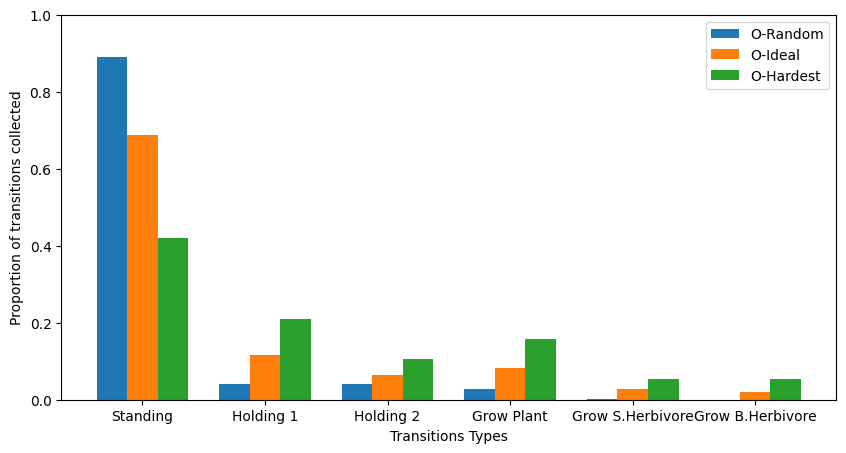

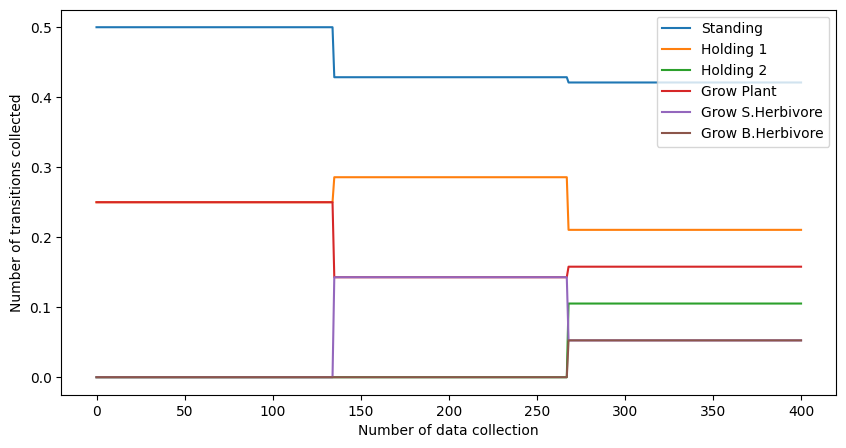

In [6]:
# Plot the distribution of collected transitions for each algorithm
plt.figure(figsize=(10, 5))
for incr, b_name in enumerate(["O-Random", "O-Ideal", "O-Hardest"]):
    _values = [np.mean([all_used_transitions[b_name][seed,0].get(key,0) for seed in range(all_used_transitions[b_name].shape[0])]) for key in dict_index_transition.keys()]
    plt.bar(
        np.arange(len(dict_index_transition.keys()))+0.25*incr,
        _values/np.sum(_values),
        label=b_name,
        width=0.25,
    )
plt.xticks([i+0.25 for i in range(len(dict_index_transition.keys()))], dict_index_transition.keys())
plt.xlabel("Transitions Types")
plt.ylabel("Proportion of transitions collected")
plt.ylim([0, 1])
plt.legend()

# Same for O-curriculum
plt.figure(figsize=(10, 5))
for transition_type in dict_index_transition.keys():
    values = [all_used_transitions["O-Curriculum"][0,incr].get(transition_type,0)/np.sum(list(all_used_transitions["O-Curriculum"][0,incr].values())) for incr in range(all_used_transitions["O-Curriculum"][0].shape[0])]
    plt.plot(values, label=transition_type)
plt.xlabel("Number of data collection")
plt.ylabel("Number of transitions collected")
plt.legend()
plt.show()

## Rules generated

Text(0.5, 1.0, 'Number of rules kept')

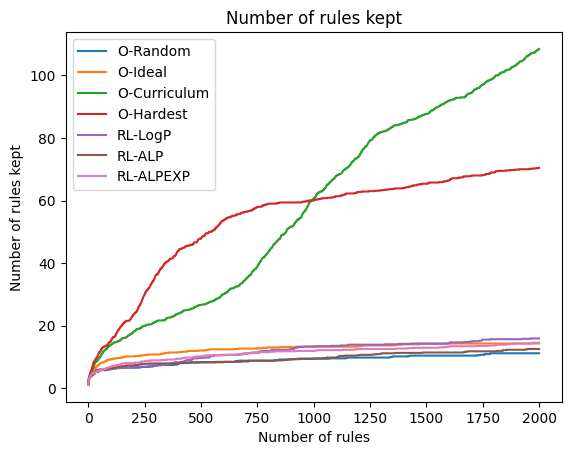

In [7]:
plt.figure()
for algo in all_baselines_name:
    _result_seed = []
    for seed in range(len(all_data[algo])):
        _indices_change_rule = np.unique(all_data[algo][seed]["metrics"]["prev_rules_ind"])
        new_rules_cum_change = [sum(1 for i in _indices_change_rule if i+1 <= pos) for pos in range(len(all_data[algo][seed]["rules"]))]
        _result_seed.append(new_rules_cum_change)
    plt.plot(np.mean(_result_seed, axis=0), label=algo)
plt.xlabel("Number of rules")
plt.ylabel("Number of rules kept")
plt.legend()
plt.title("Number of rules kept")

Text(0.5, 1.0, 'Number of rules kept')

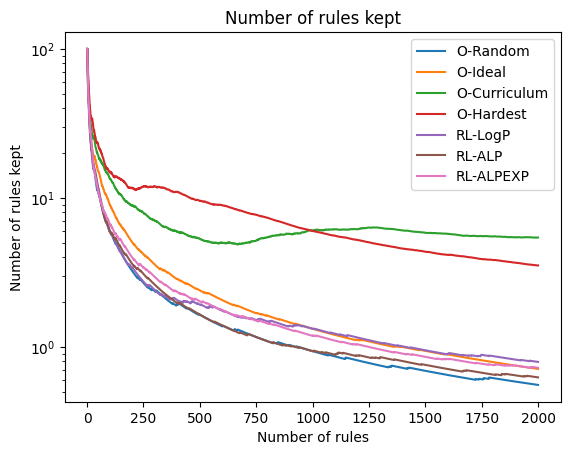

In [8]:
plt.figure()
for algo in all_baselines_name:
    _result_seed = []
    for seed in range(len(all_data[algo])):
        _indices_change_rule = np.unique(all_data[algo][seed]["metrics"]["prev_rules_ind"])
        new_rules_cum_change = [100*sum(1 for i in _indices_change_rule if i+1 <= pos)/(pos+1) for pos in range(0,len(all_data[algo][seed]["rules"]))]
        _result_seed.append(new_rules_cum_change)
        
    plt.plot(np.mean(_result_seed, axis=0), label=algo)
    plt.yscale("log")
plt.xlabel("Number of rules")
plt.ylabel("Number of rules kept")
plt.legend()
plt.title("Number of rules kept")

Text(0.5, 1.0, 'Percentage of hypotheses kept as a function of the Metropolis algorithm inference.')

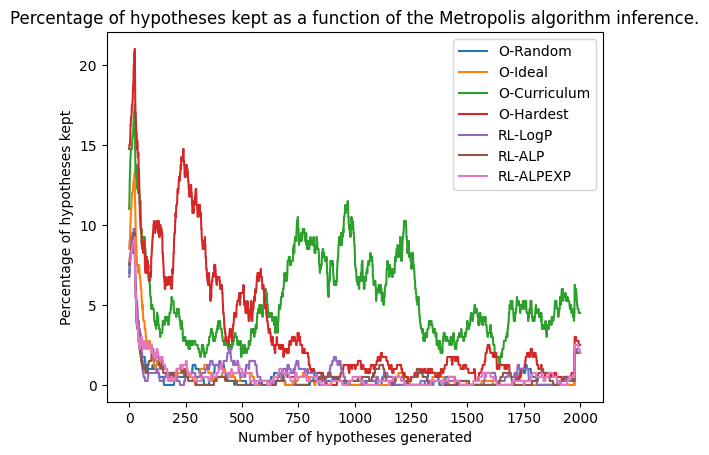

In [10]:
plt.figure()
for algo in all_baselines_name:
    _result_seed = []
    for seed in range(len(all_data[algo])):
        _indices_change_rule = np.unique(all_data[algo][seed]["metrics"]["prev_rules_ind"])
        _spikes_val = np.zeros(len(all_data[algo][seed]["rules"]))
        _spikes_val[_indices_change_rule] = 1
        new_rules_cum_change = np.convolve(_spikes_val, np.ones(50)/50, mode='same')
        _result_seed.append(new_rules_cum_change)
        
    plt.plot(100*np.mean(_result_seed, axis=0), label=algo)
    # plt.yscale("log")
plt.xlabel("Number of hypotheses generated")
plt.ylabel("Percentage of hypotheses kept")
plt.legend()
plt.title("Percentage of hypotheses kept as a function of the Metropolis algorithm inference.")

In [10]:
for algo in []:
    print(f"# {algo}")
    for incr, rule in enumerate(all_best_rules[algo][:,-1]):
        print(repr(rule)+": "+ str(all_best_likelihoods[algo][incr,-1]))

In [11]:
for algo in []:
    print(f"# {algo}")
    for rule in all_best_rules[algo][:,-1]:
        print(repr(rule)+",")

In [12]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'O-Random' Color: Red
Baseline: 'O-Ideal' Color: Green
Baseline: 'O-Curriculum' Color: Blue
Baseline: 'O-Hardest' Color: Magenta
Baseline: 'RL-LogP' Color: Cyan
Baseline: 'RL-ALP' Color: White
Baseline: 'RL-ALPEXP' Color: Yellow
-----rule-----:0: '1. If the action is \'You go to\' and the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, wolf), predict "You are standing on the [object]."\n2. If you are standing on an animal\'s seed and the action is \'You give the water\', predict "The objects transform into the [animal]."\n3. If the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, or wolf) and the action is \'You give the water\', predict "The objects transform into the [animal]."\n4. If you are standing on the water and the action is \'You pick up\', predict "In your inventory, there is the water."\n5. If you are standing on the water and the action is \'You pick up the object\', predi

In [13]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for O-Random: [3, 0, 1, 0, 0, 0, 0, 0]
Number of same rules per particle for O-Ideal: [0, 1, 0, 61, 4, 2, 1, 8]
Number of same rules per particle for O-Curriculum: [157, 55, 27, 237, 13, 43, 135, 102]
Number of same rules per particle for O-Hardest: [125, 294, 140, 19, 299, 93, 29, 417]
Number of same rules per particle for RL-LogP: [0, 2, 0, 1, 0, 0, 0, 0]
Number of same rules per particle for RL-ALP: [0, 0, 0, 0, 0, 0, 0, 0]
Number of same rules per particle for RL-ALPEXP: [1, 0, 0, 0, 0, 1, 0, 0]


## Comparison across seeds

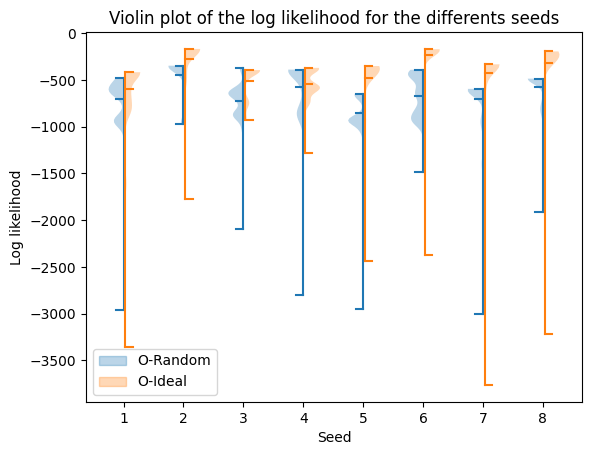

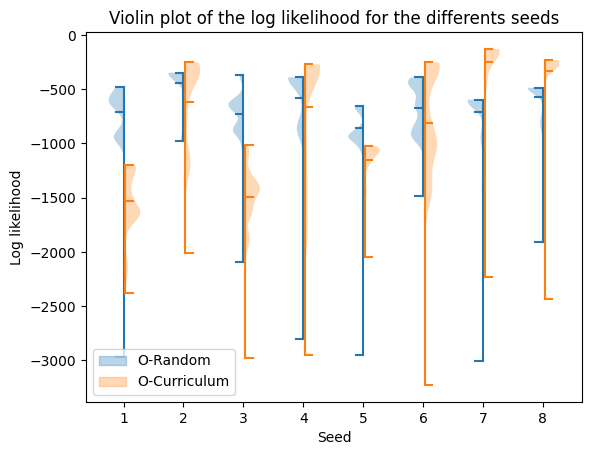

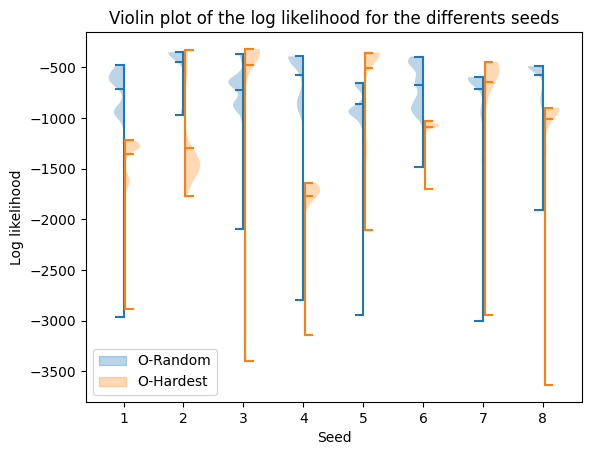

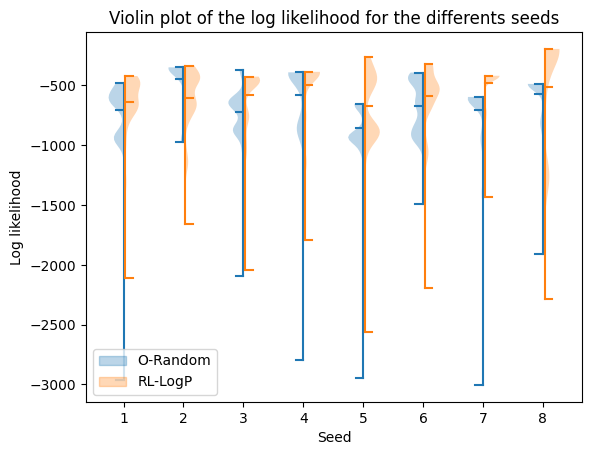

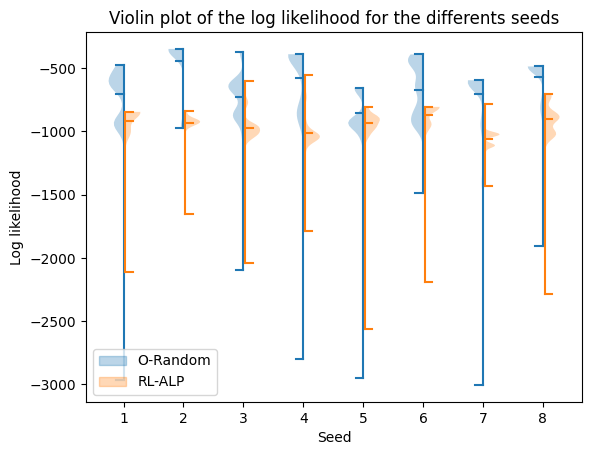

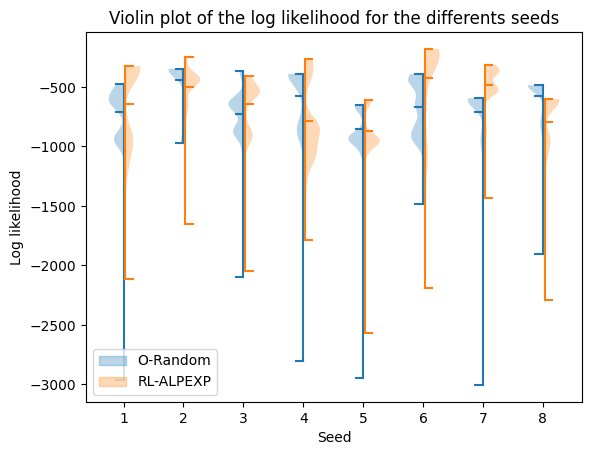

In [14]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_best_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_best_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_best_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

## Comparaison collecte de données

In [15]:
for transi_type, value in dict_index_transition.items():
    print(transi_type +": "+ str(len(value)))

Standing: 120
Holding 1: 20
Holding 2: 7
Grow Plant: 12
Grow S.Herbivore: 6
Grow B.Herbivore: 3


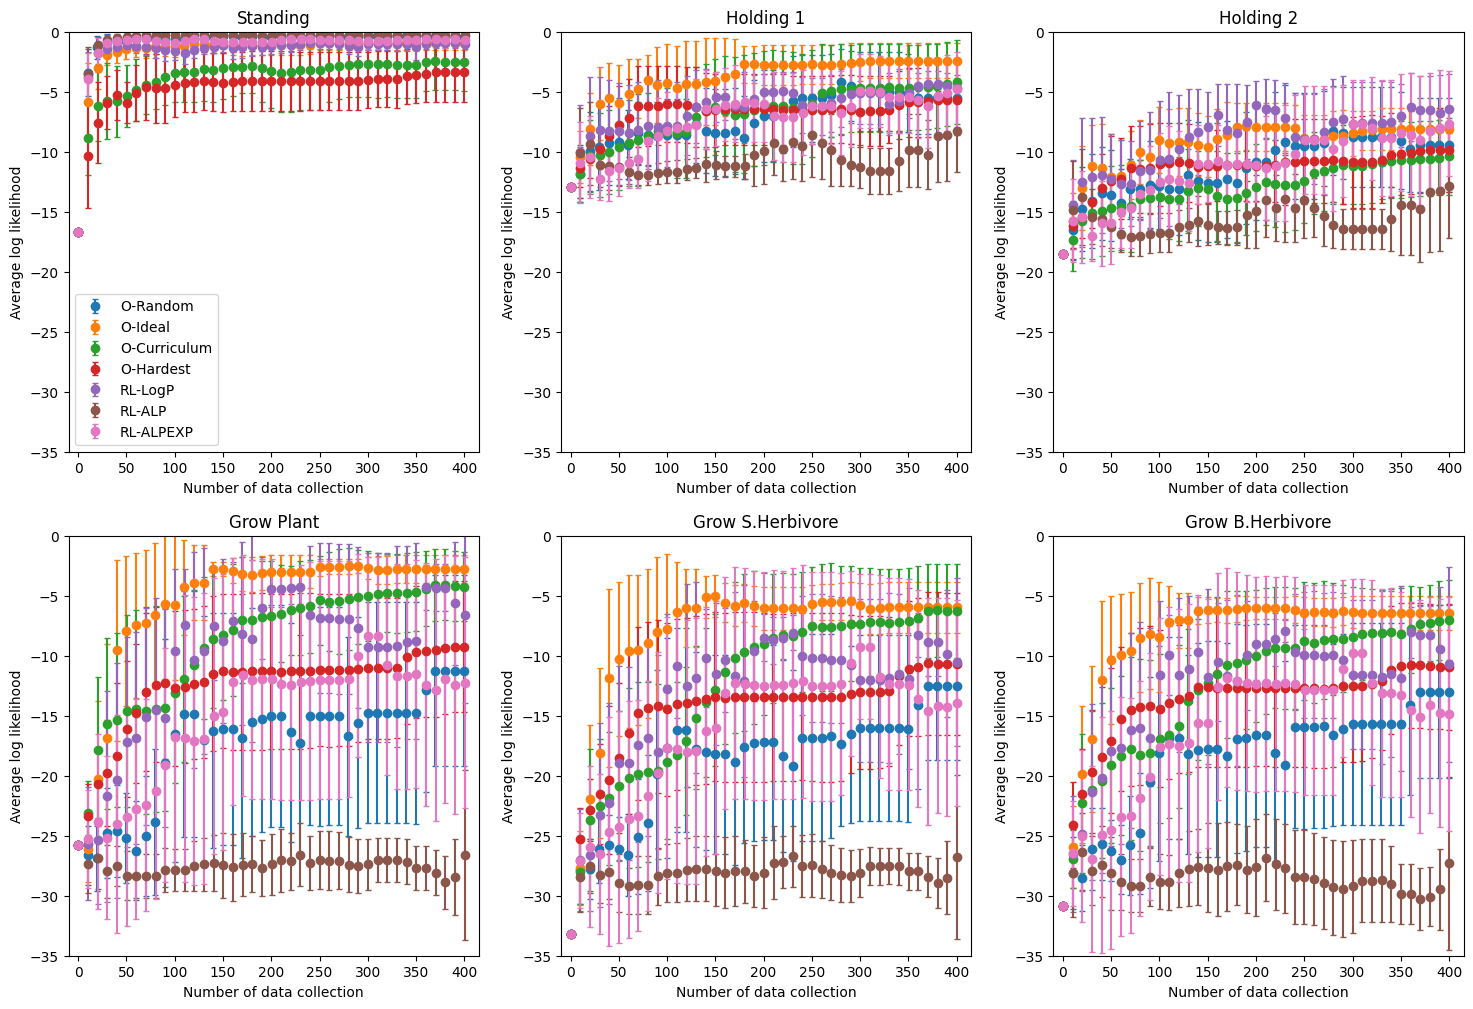

In [16]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.subplots(2,3, figsize=(18,12))
for incr_tran, transi_type in enumerate(dict_index_transition):
    plt.subplot(2,3, incr_tran+1)

    for incr,b_name in enumerate(all_baselines_name):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_median_ll = np.convolve(np.median(_ll_per_transition, axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        average_median_ll = np.insert(average_median_ll,0, np.median(_norule_likelihood_transition, axis=0), axis=0)
        #Plot
        # plt.plot(average_size*np.arange(len(average_median_ll))+ incr*0.05, average_median_ll, label=b_name)
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=b_name, capsize=2, fmt='o')
        plt.ylim(-35, 0)
        plt.xlim(-10, 415)
    # plt.hlines(y=_norule_likelihood_transition.mean(axis=0), xmin=0, xmax=405, color='black', linestyle='--', label="No rule")
    plt.xlabel("Number of data collection")
    plt.ylabel("Average log likelihood")
    plt.title(f"{transi_type}")
plt.subplot(2,3, 1)
plt.legend()
plt.show()

In [17]:
_aac_no_rule = []
#Compute for no rule
for incr_tran, transi_type in enumerate(dict_index_transition):
    _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
    _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[1], axis=0)
    _aac_no_rule.append(np.trapz(-_norule_likelihood_transition))
    print(f"No rule: {np.trapz(-_norule_likelihood_transition):.2f}", end=" ")
print()

# Compute area above the curve
for incr_tran, transi_type in enumerate(dict_index_transition):
    print(f"\nArea under the curve for {transi_type}:", end=" ")
    for incr,b_name in enumerate(all_baselines_name):
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        print(f"{b_name}: {1-np.trapz(-_ll_per_transition.mean(axis=0))/_aac_no_rule[incr_tran]:.2f}", end=" ")



print()
        
# Compute area above the curve, print for overleaf
for incr,b_name in enumerate(all_baselines_name):
    print(f"{b_name}",end="")
    for incr_tran, transi_type in enumerate(dict_index_transition):
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        print(f" & {1-np.trapz(-_ll_per_transition.mean(axis=0)/_aac_no_rule[incr_tran]):.2f} $\pm$ {np.std(np.trapz(_ll_per_transition/_aac_no_rule[incr_tran]), axis=0):.2f}", end="")
    print("\\\\")

No rule: 6688.89 No rule: 5162.97 No rule: 7420.02 No rule: 10324.58 No rule: 13262.96 No rule: 12336.29 

Area under the curve for Standing: O-Random: 0.97 O-Ideal: 0.92 O-Curriculum: 0.79 O-Hardest: 0.74 RL-LogP: 0.93 RL-ALP: 0.98 RL-ALPEXP: 0.95 
Area under the curve for Holding 1: O-Random: 0.45 O-Ideal: 0.72 O-Curriculum: 0.48 O-Hardest: 0.48 RL-LogP: 0.52 RL-ALP: 0.18 RL-ALPEXP: 0.44 
Area under the curve for Holding 2: O-Random: 0.40 O-Ideal: 0.50 O-Curriculum: 0.31 O-Hardest: 0.39 RL-LogP: 0.53 RL-ALP: 0.17 RL-ALPEXP: 0.40 
Area under the curve for Grow Plant: O-Random: 0.34 O-Ideal: 0.81 O-Curriculum: 0.67 O-Hardest: 0.52 RL-LogP: 0.62 RL-ALP: -0.07 RL-ALPEXP: 0.42 
Area under the curve for Grow S.Herbivore: O-Random: 0.44 O-Ideal: 0.77 O-Curriculum: 0.63 O-Hardest: 0.57 RL-LogP: 0.61 RL-ALP: 0.16 RL-ALPEXP: 0.52 
Area under the curve for Grow B.Herbivore: O-Random: 0.40 O-Ideal: 0.74 O-Curriculum: 0.60 O-Hardest: 0.56 RL-LogP: 0.60 RL-ALP: 0.08 RL-ALPEXP: 0.49 
O-Random & 0.9

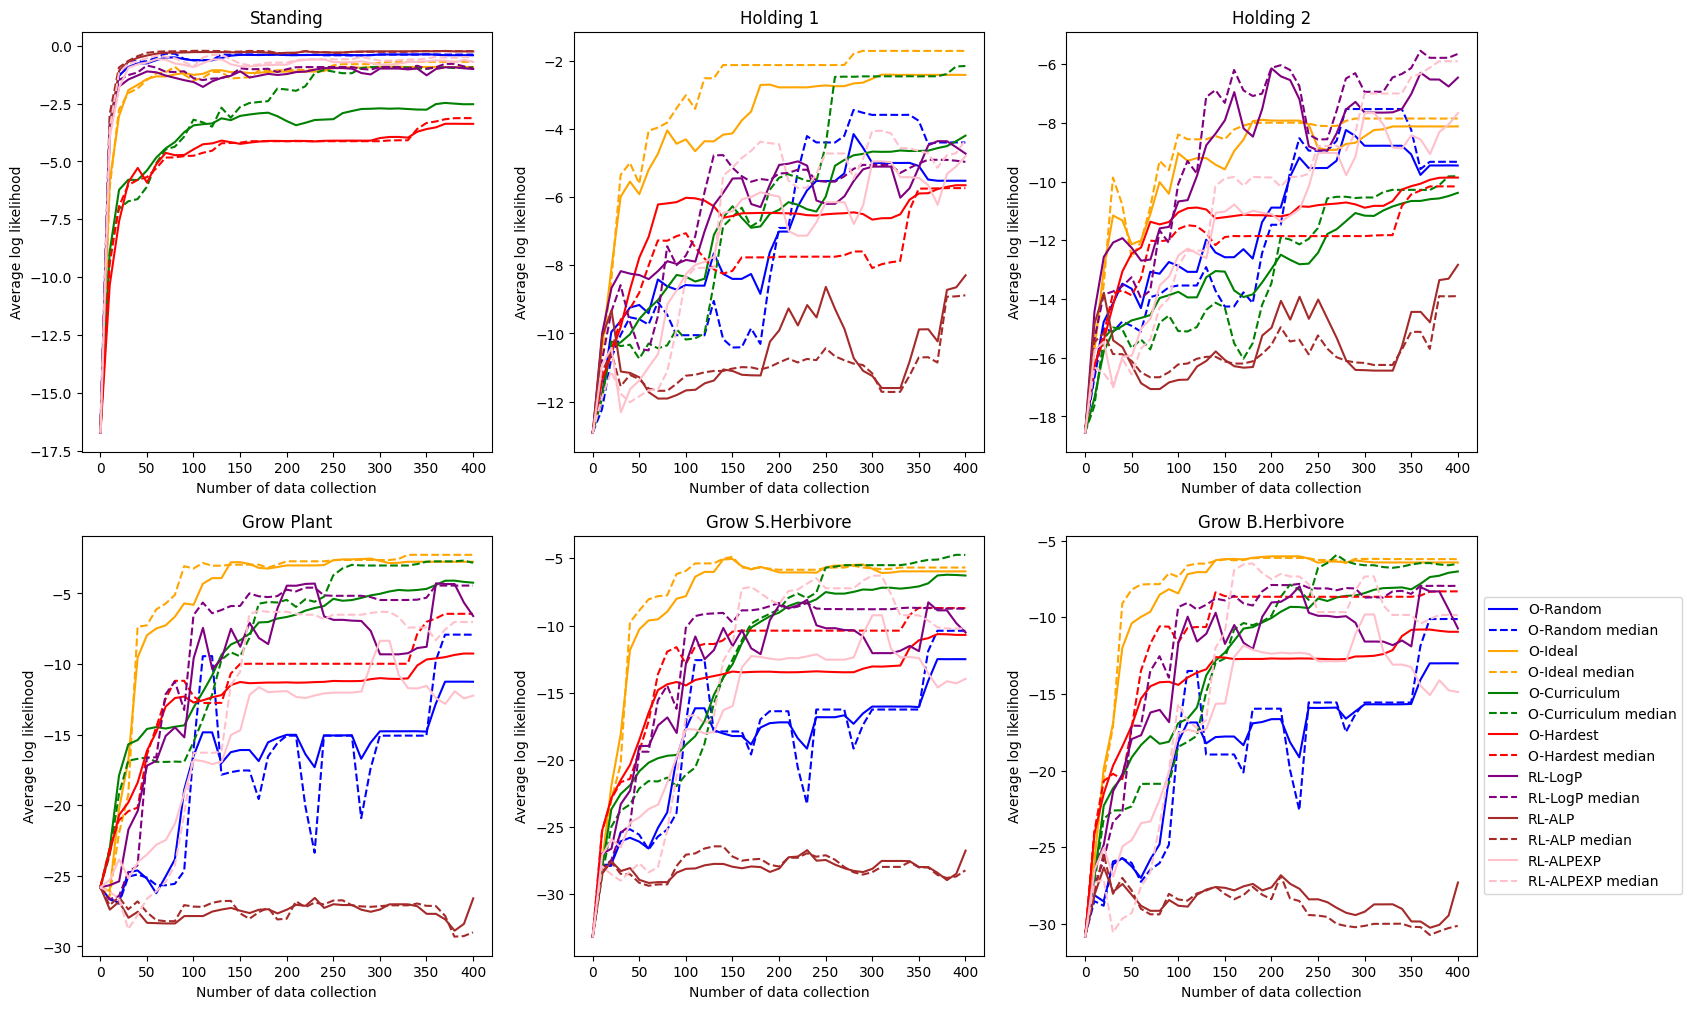

In [18]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.subplots(2,3, figsize=(18,12))
for incr_tran, transi_type in enumerate(dict_index_transition):
    plt.subplot(2,3, incr_tran+1)
    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

    for incr,b_name in enumerate(all_baselines_name):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_median_ll = np.convolve(np.median(_ll_per_transition, axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        average_median_ll = np.insert(average_median_ll,0, np.median(_norule_likelihood_transition, axis=0), axis=0)
        #Plot
        plt.plot(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, label=b_name, color=colors[incr])
        plt.plot(average_size*np.arange(len(average_median_ll)), average_median_ll, label=b_name+" median", linestyle='--', color=colors[incr])
    plt.xlabel("Number of data collection")
    plt.ylabel("Average log likelihood")
    plt.title(f"{transi_type}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

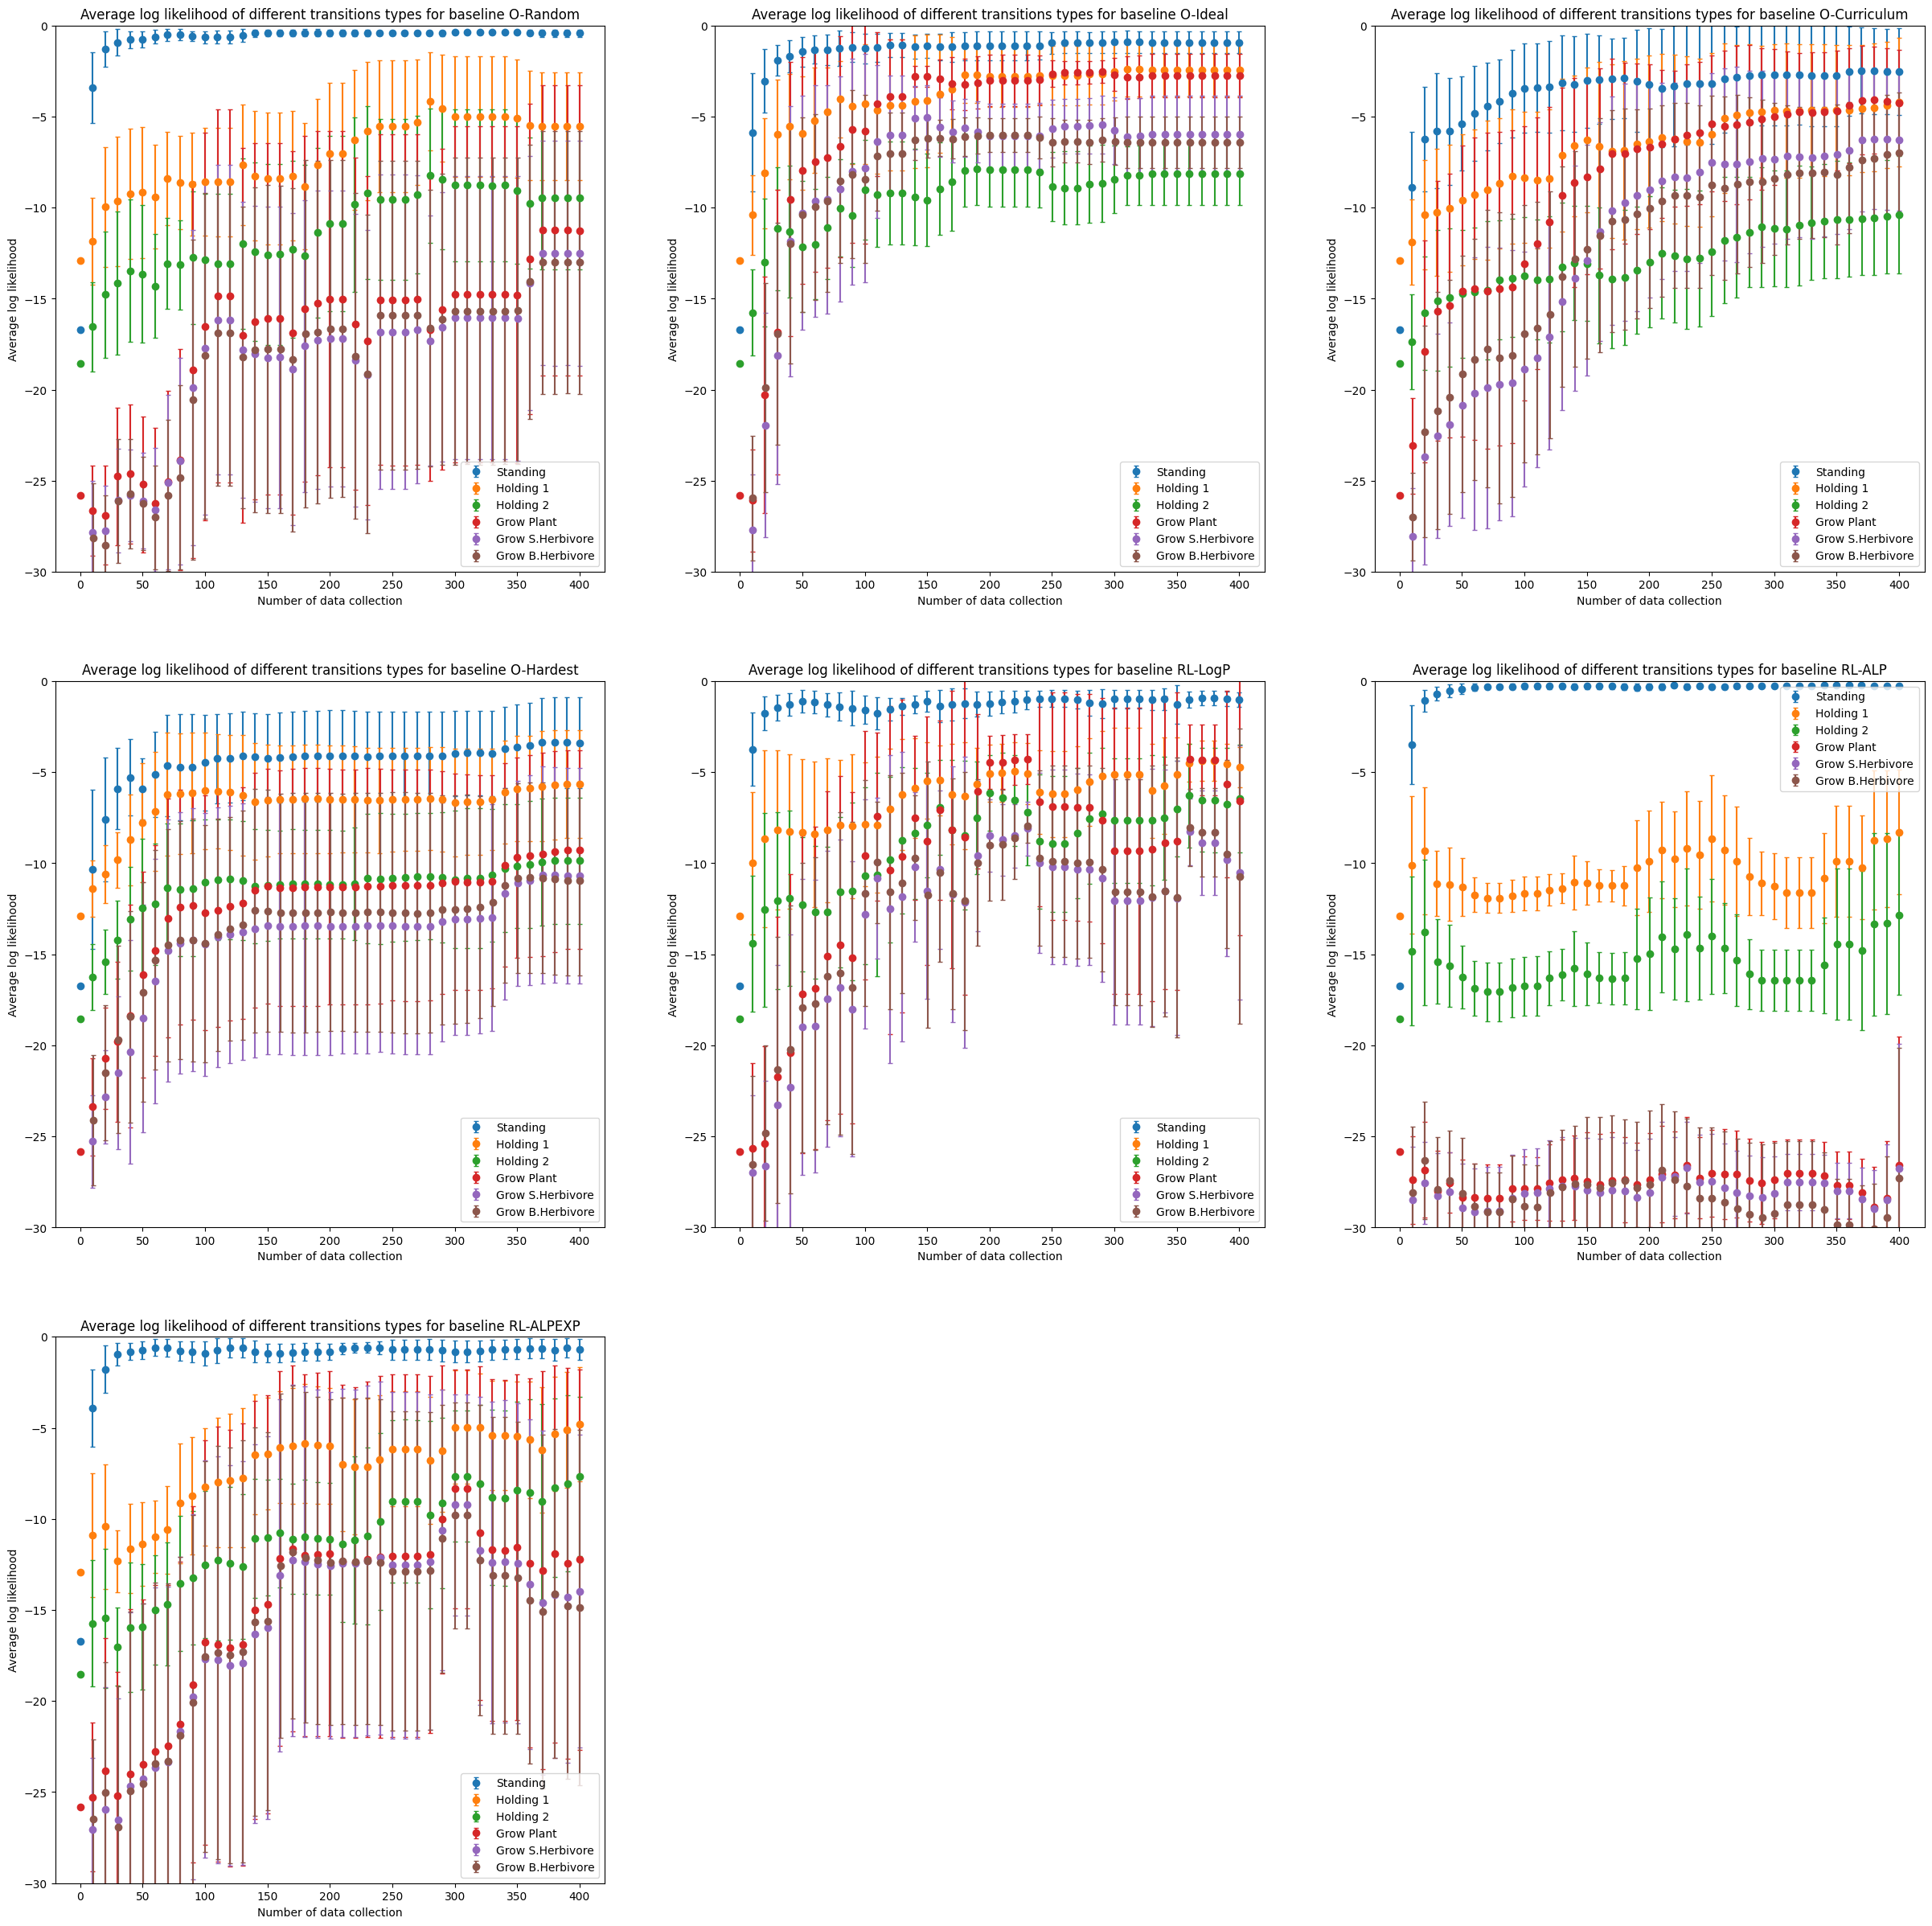

In [19]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for incr_m, b_name in enumerate(all_baselines_name):
    plt.subplot(3,3,incr_m+1)
    for incr, transi_type in enumerate(dict_index_transition):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        #Plot
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=transi_type, capsize=2, fmt='o')
    
    plt.legend()
    plt.xlabel("Number of data collection")
    plt.ylim((-30,0))
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for baseline {b_name}")


## Likelihood as a function of collected transition

In [20]:
_norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
# Build cumulative count for each seed and transition
cumul_transition = {algo_name:{k: np.zeros(all_used_transitions[algo_name].shape) for k in dict_index_transition.keys()} for algo_name in all_used_transitions}
ll_per_transition = {algo_name:{transi_type: all_best_transition_ll[algo_name][:,:,dict_index_transition[transi_type]].mean(axis=-1) for transi_type in dict_index_transition} for algo_name in all_used_transitions}
for algo_name in all_used_transitions:
    for i_seed, used_transitions_per_seed in enumerate(all_used_transitions[algo_name]):
        for i_data_collect, used_transitions_per_collect in enumerate(used_transitions_per_seed):
            for transition_type in dict_index_transition:
                cumul_transition[algo_name][transition_type][i_seed, i_data_collect] = cumul_transition[algo_name][transition_type][i_seed, i_data_collect-1] + used_transitions_per_collect.get(transition_type, 0)
                

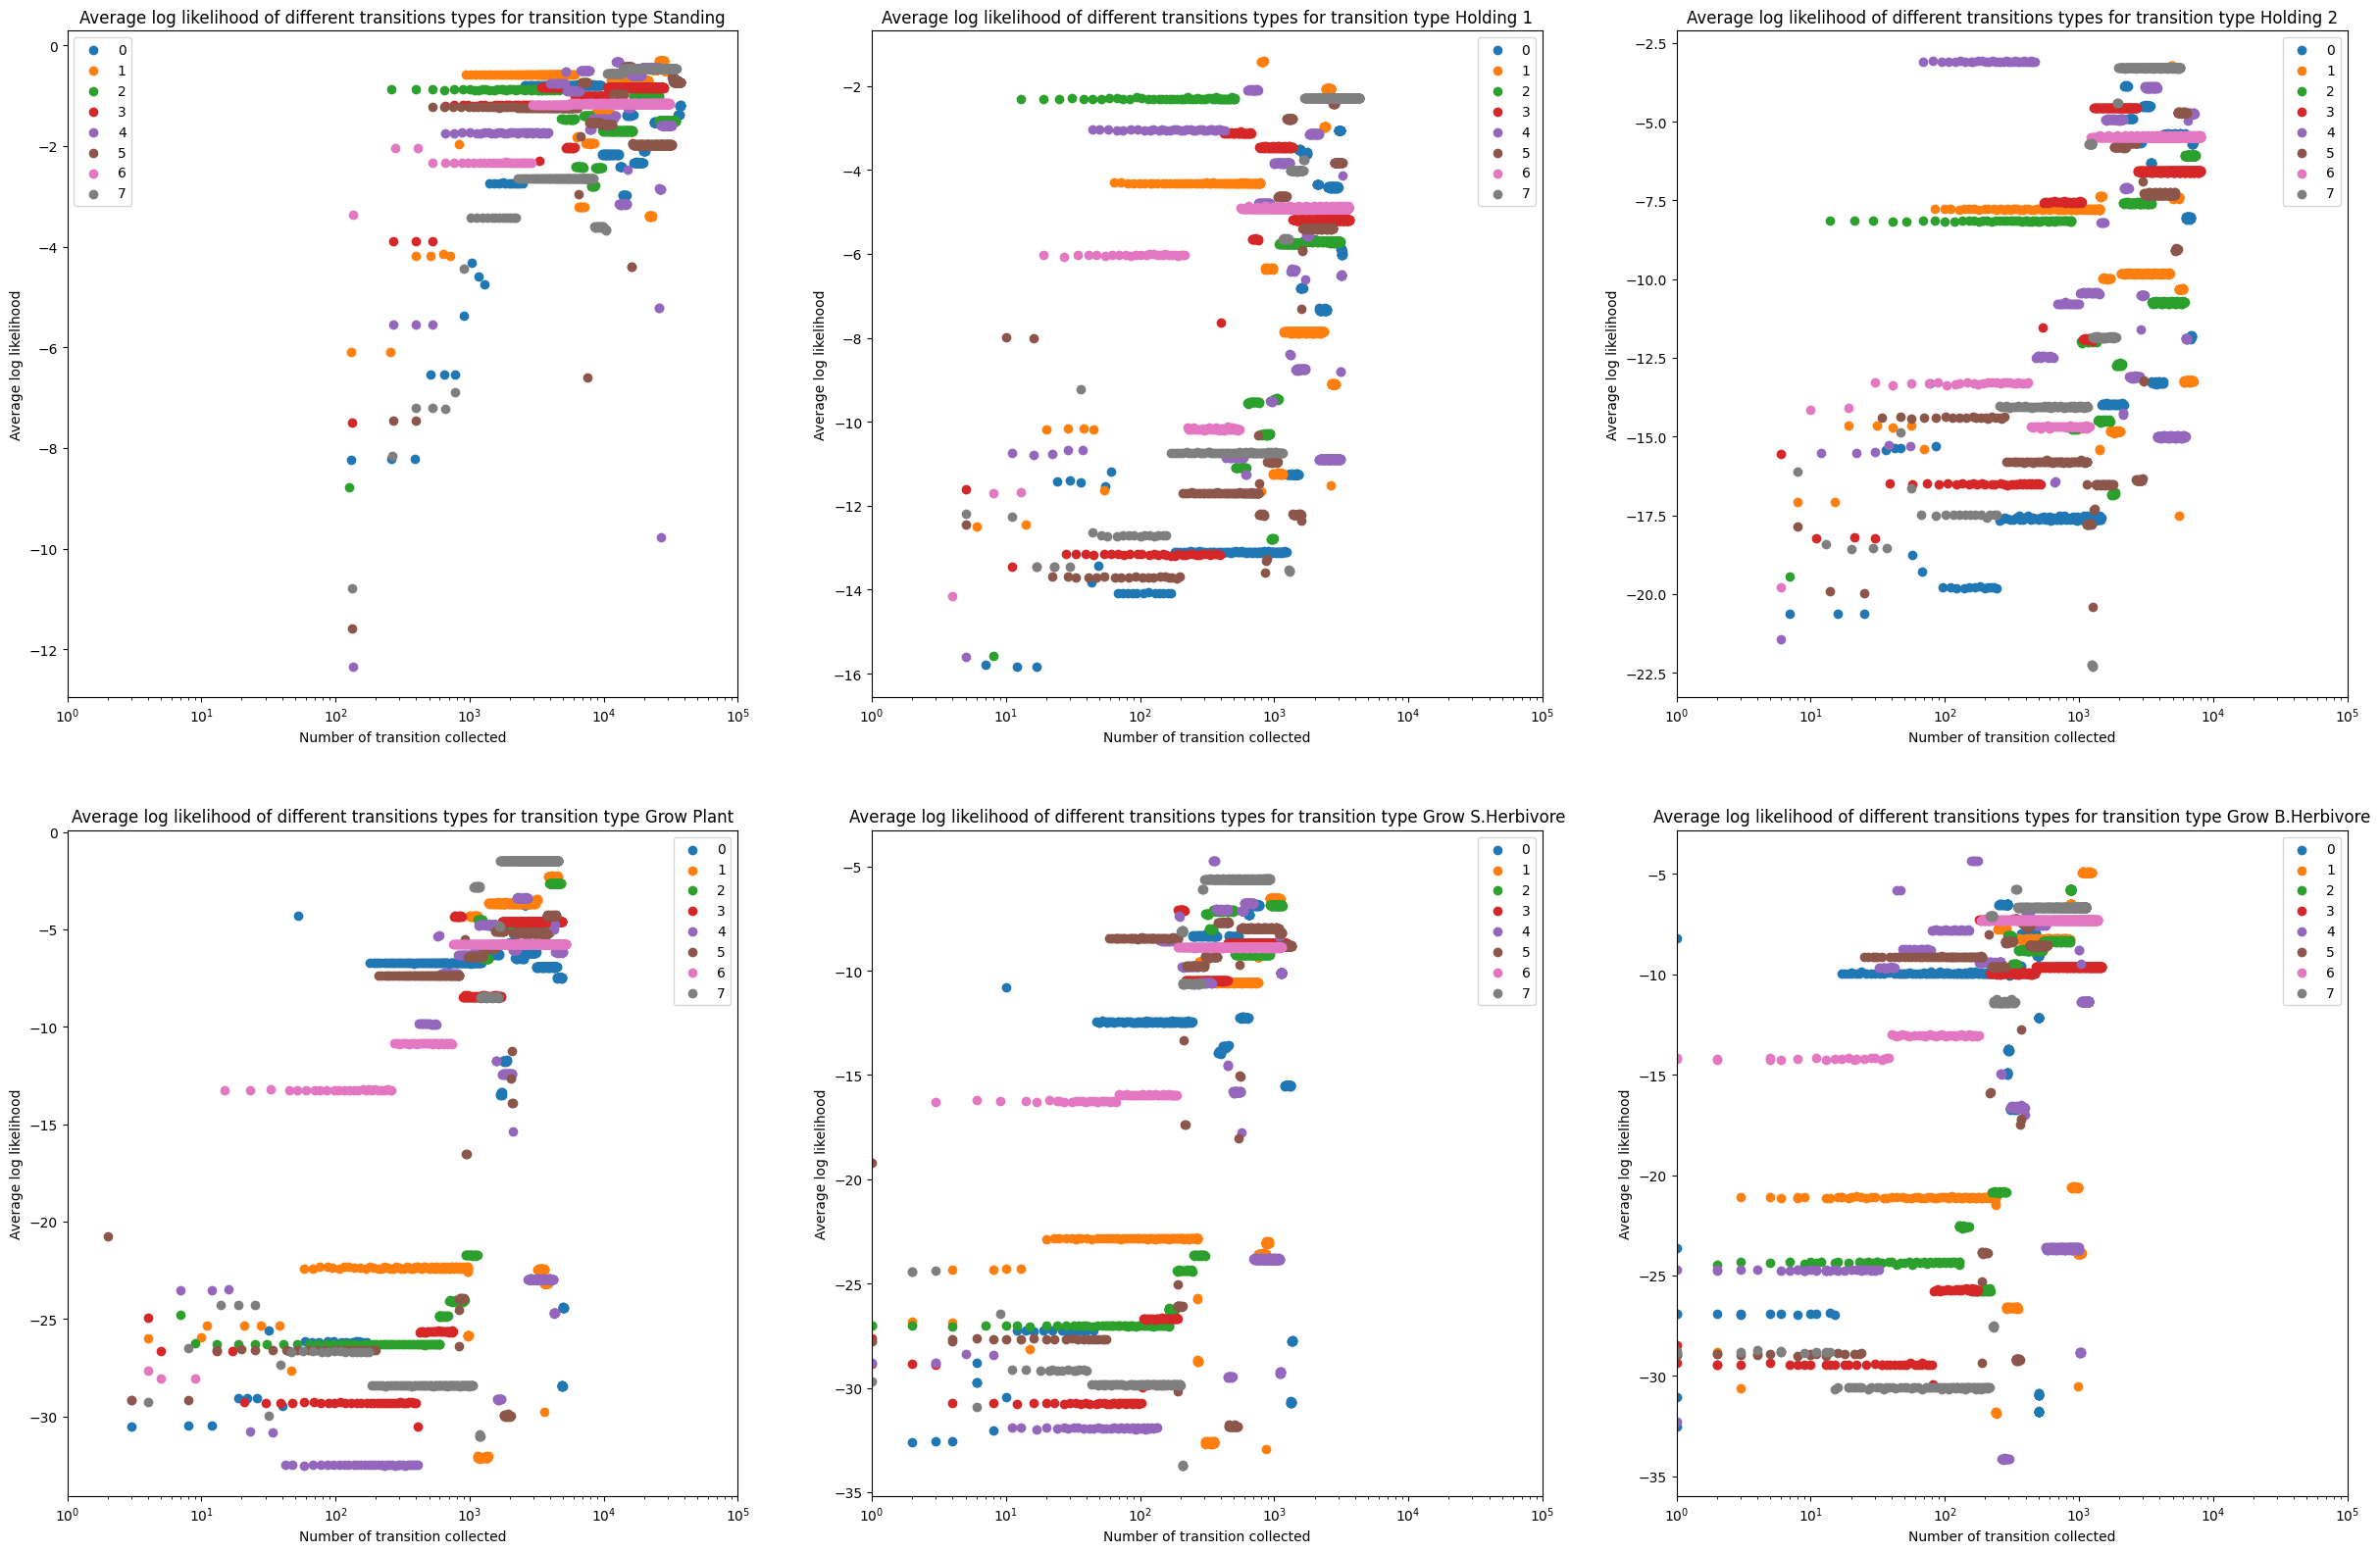

In [21]:
# Scatter plot for each transtion type for specific algo
algo_name = "RL-LogP"

plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(cumul_transition[algo_name]):
    plt.subplot(3,3,i_tt+1)
    for seed in range(cumul_transition[algo_name][transition_type].shape[0]):
        plt.scatter(cumul_transition[algo_name][transition_type][seed], ll_per_transition[algo_name][transition_type][seed], label=seed)
        plt.xlim(1, 10**5)
        plt.xscale("log")
        # plt.yscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")

/tmp/ipykernel_5734/1165349355.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


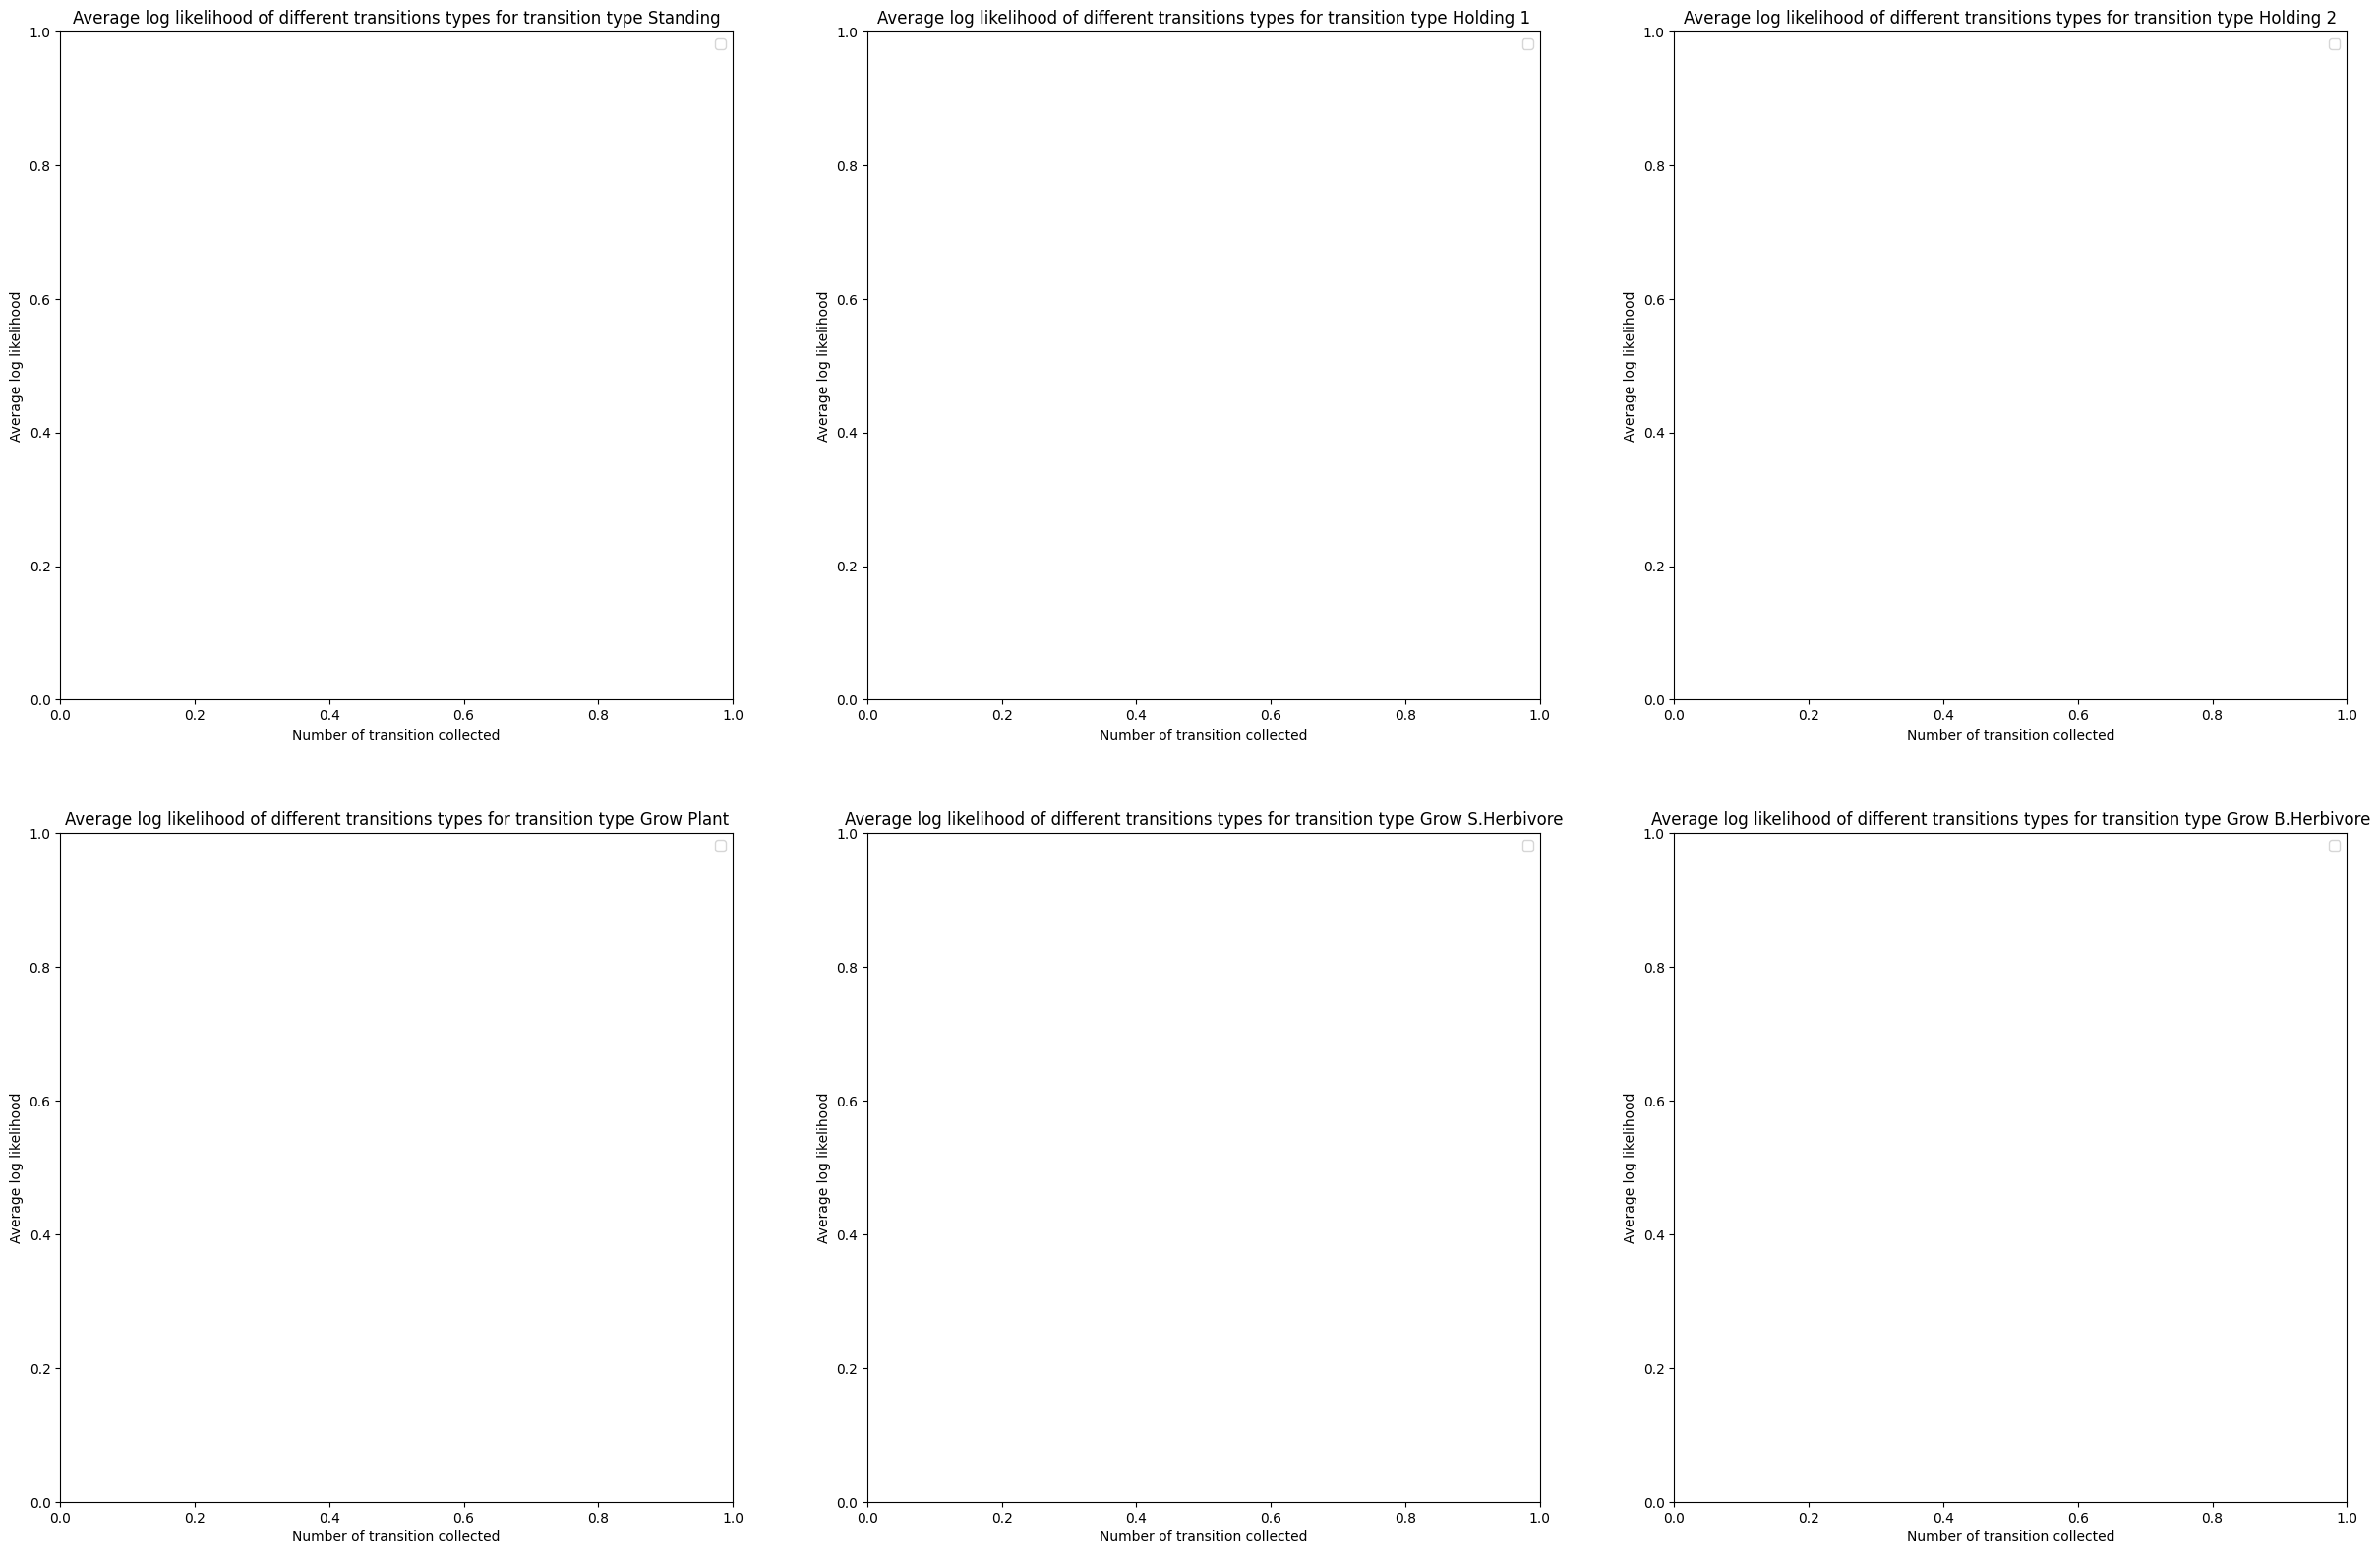

In [22]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter(cumul_transition[algo_name][transition_type].flatten(), ll_per_transition[algo_name][transition_type].flatten(), label=algo_name)
        plt.xlim(1, 10**5)
        plt.xscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


/tmp/ipykernel_5734/2474462173.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


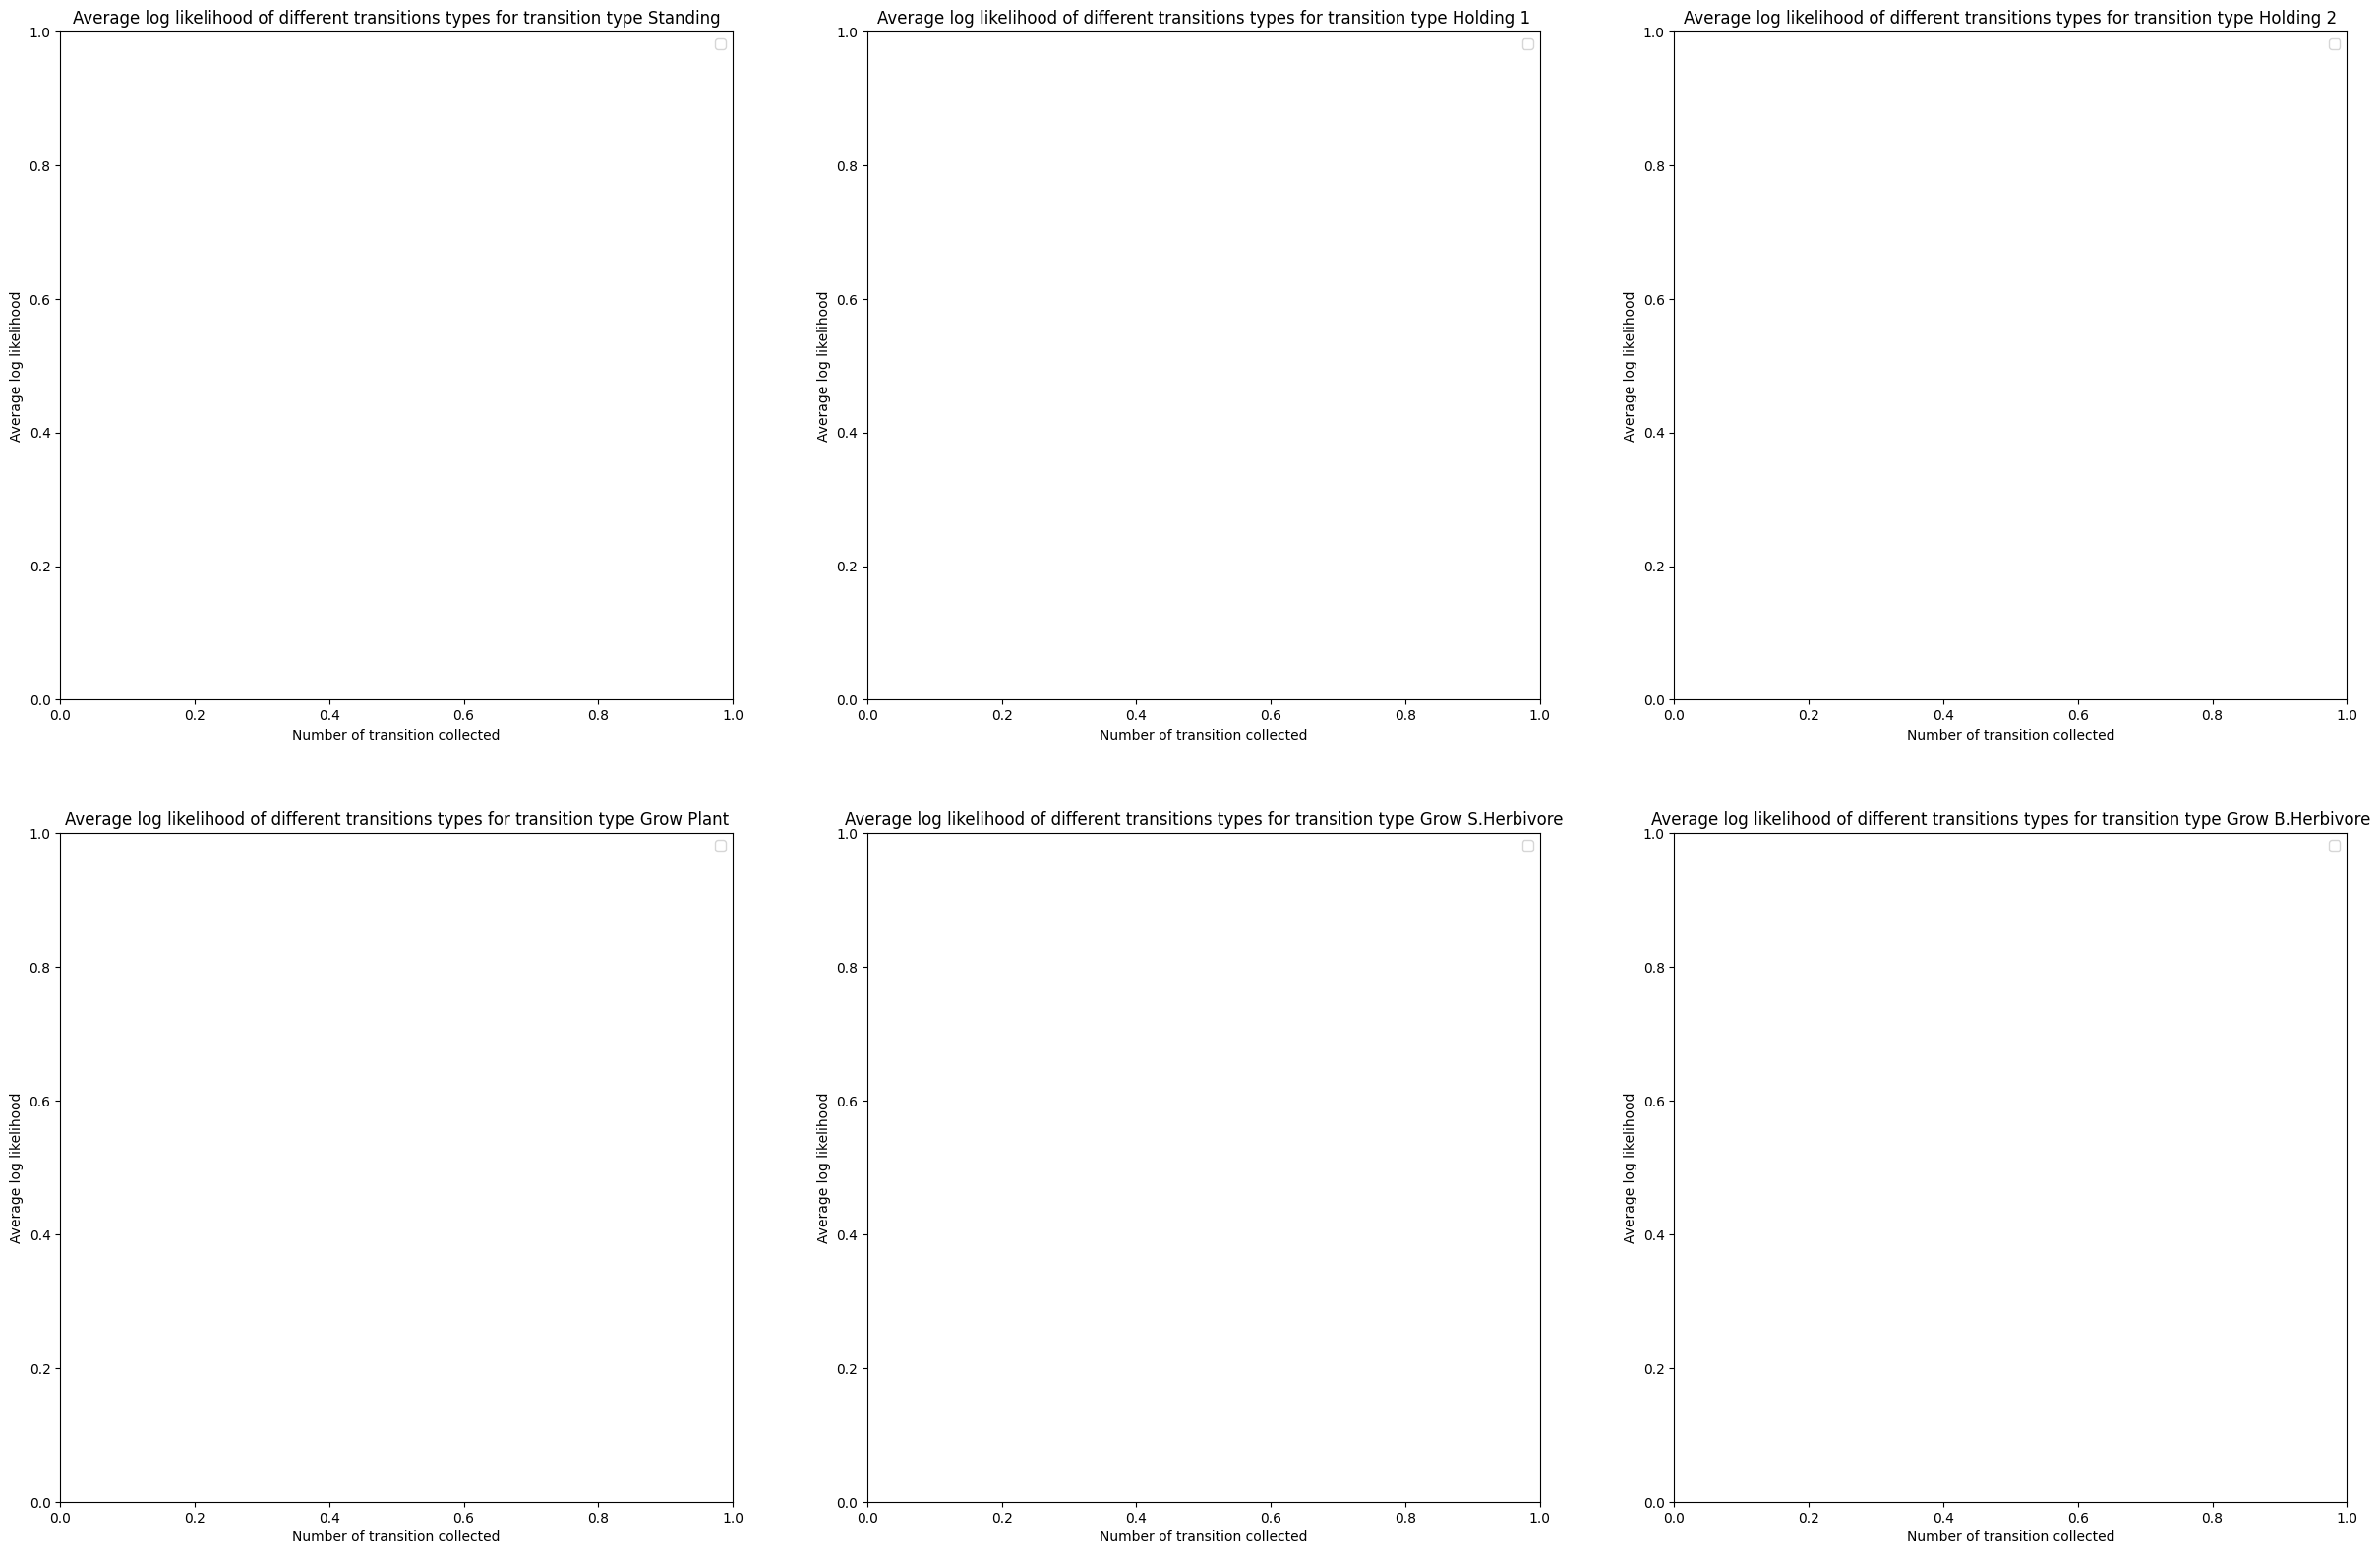

In [23]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter((cumul_transition[algo_name][transition_type]/cumul_transition[algo_name][transition_type][:,-1:]).flatten(), ll_per_transition[algo_name][transition_type].flatten(), label=algo_name)
        plt.xscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


/tmp/ipykernel_5734/389985113.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


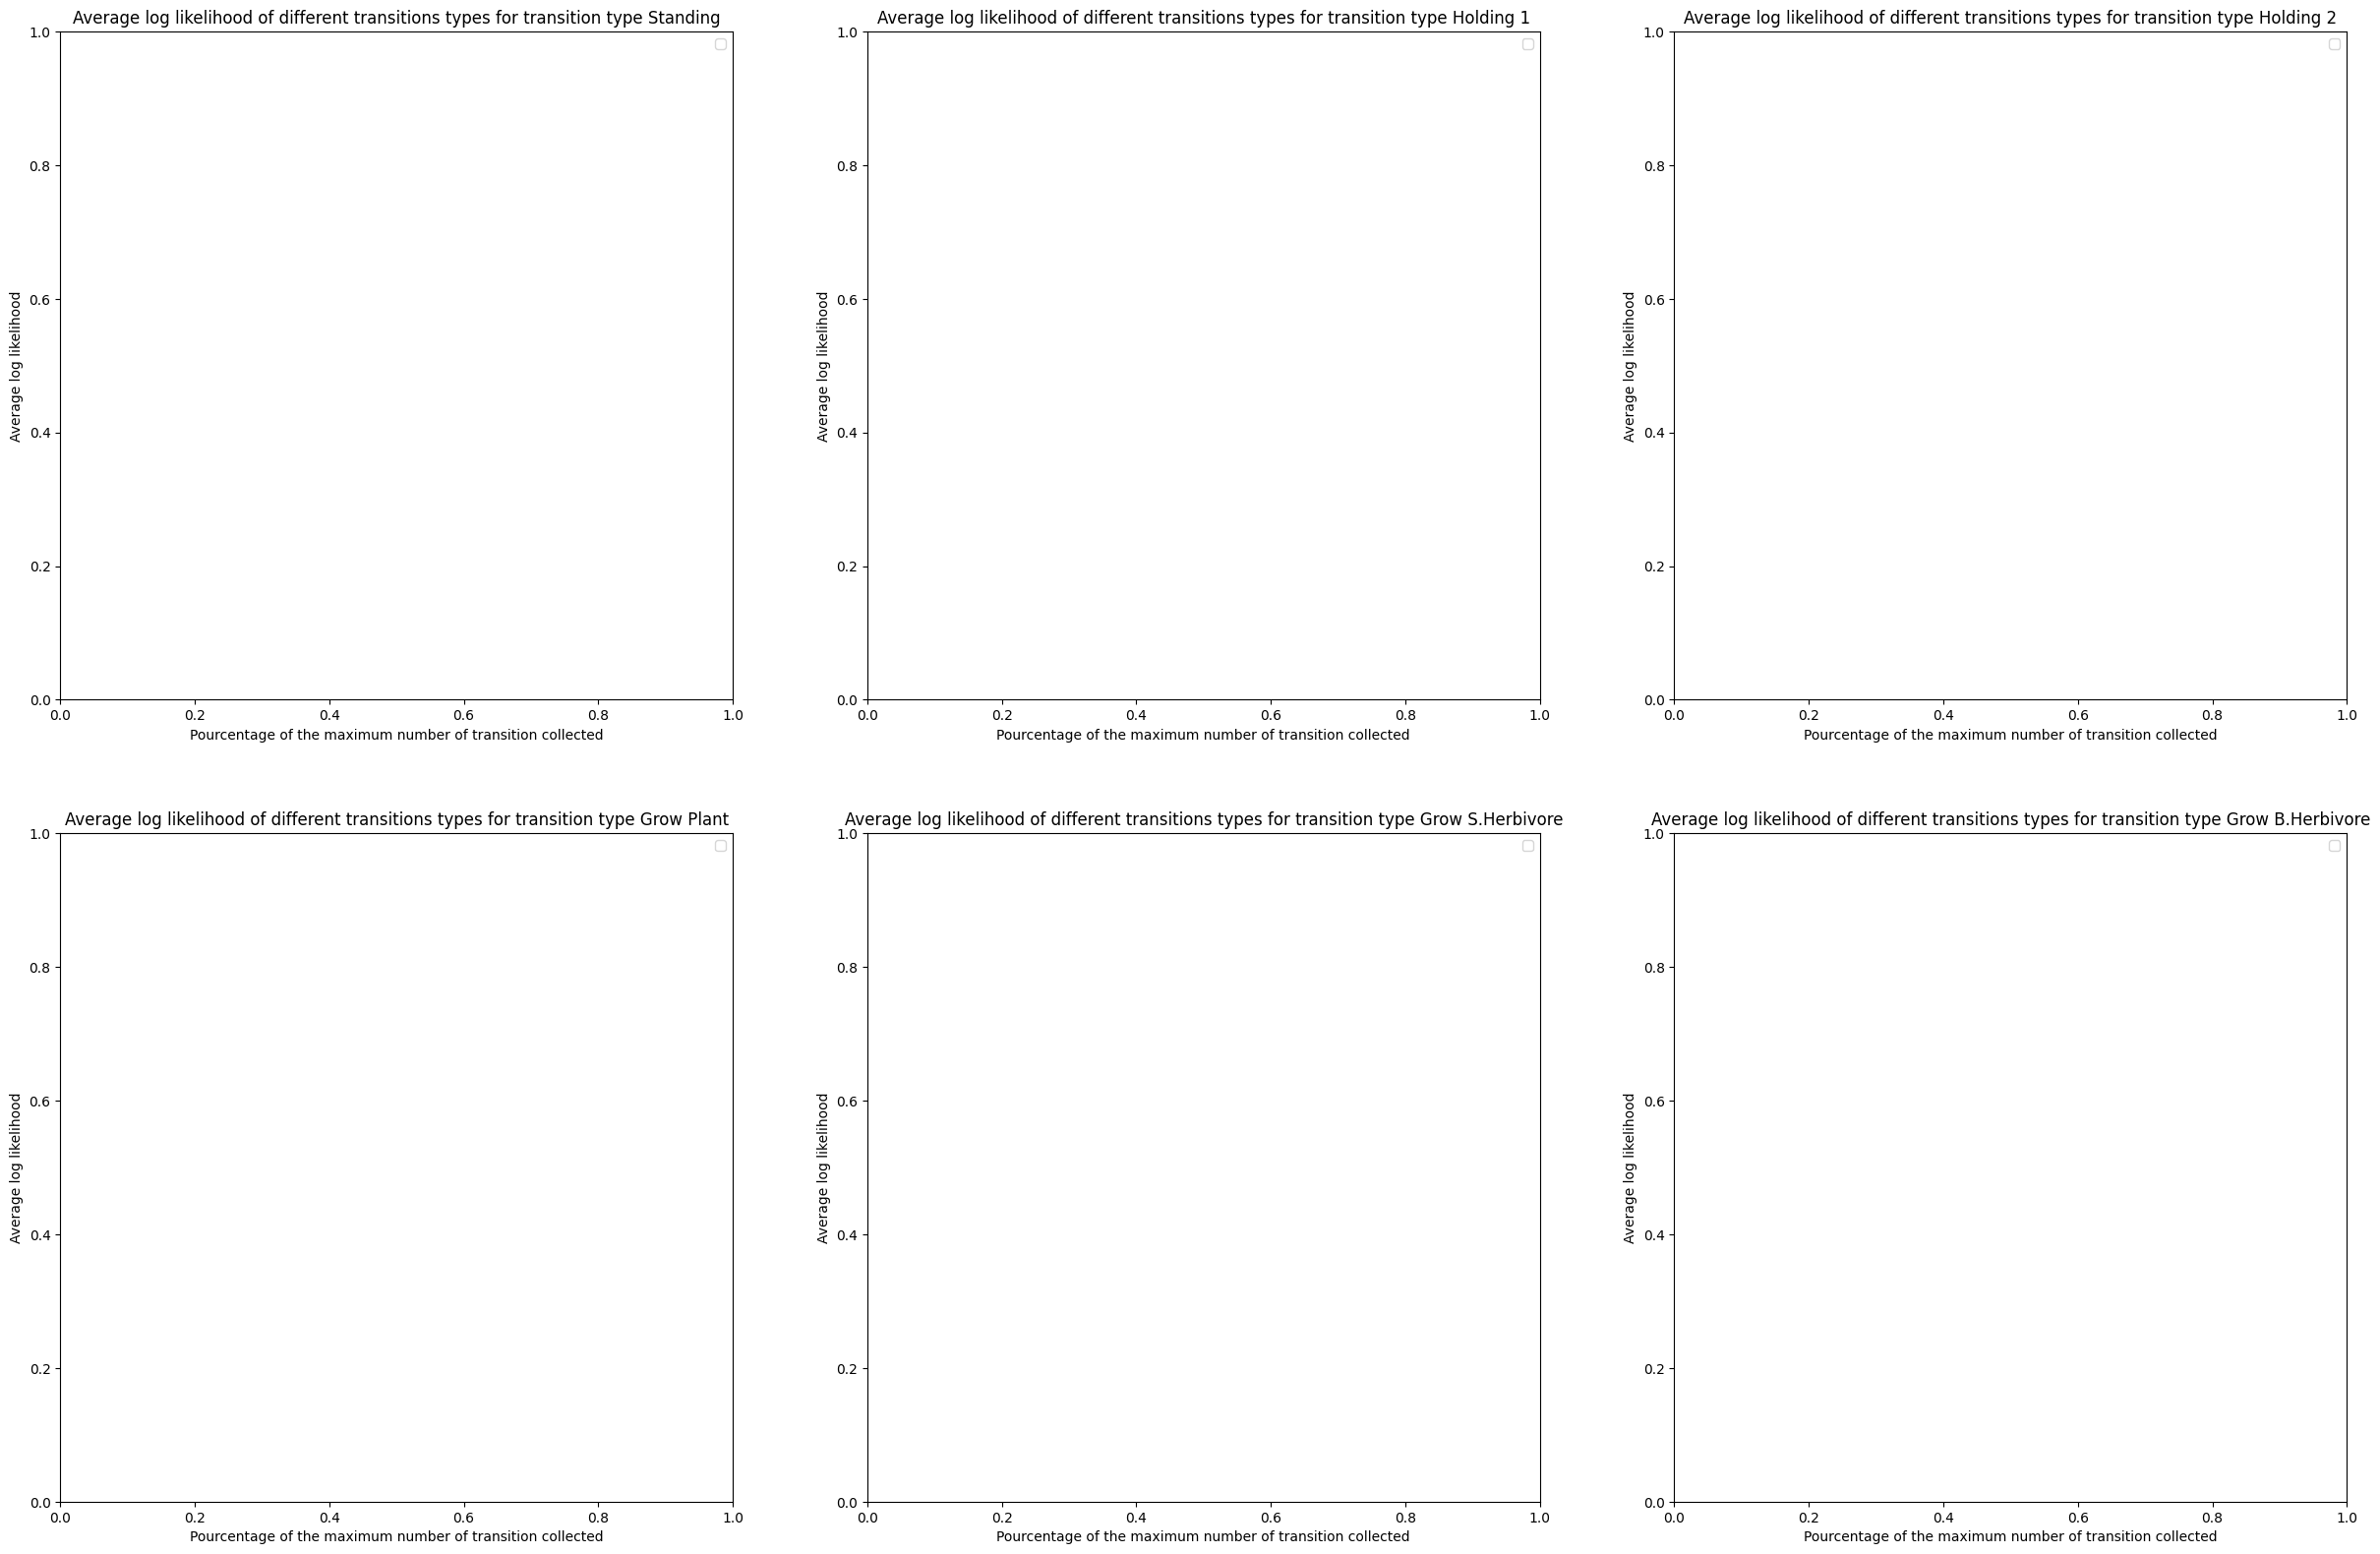

In [24]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
_seed=2
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter((cumul_transition[algo_name][transition_type]/cumul_transition[algo_name][transition_type][:,-1:])[_seed], ll_per_transition[algo_name][transition_type][_seed].flatten(), label=algo_name)
    plt.legend()
    plt.xlabel("Pourcentage of the maximum number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


## Proportion of collected transition as a function of steps

In [33]:
#Plot the collected transitions per episode for a specific algorithm
algo_name = "RL-ALP"
#Get all transitions per episode
transitions_per_episode_per_transition = {}
for transition_type in dict_index_transition:
    transitions_per_episode_per_transition[transition_type] = []
    for seed in range(all_used_transitions[algo_name].shape[0]):
        all_values = []
        for step in range(all_used_transitions[algo_name].shape[1]):
            all_values.append(all_used_transitions[algo_name][seed, step].get(transition_type, 0))
        transitions_per_episode_per_transition[transition_type].append(all_values)
    transitions_per_episode_per_transition[transition_type] = np.array(transitions_per_episode_per_transition[transition_type])

In [34]:
#Fuse Holding 1 and Holding 2
transitions_per_episode_per_transition["Holdings"] = transitions_per_episode_per_transition["Holding 1"] + transitions_per_episode_per_transition["Holding 2"]
del transitions_per_episode_per_transition["Holding 1"]
del transitions_per_episode_per_transition["Holding 2"]

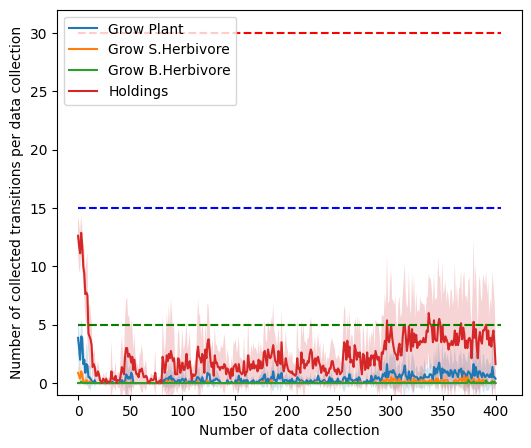

In [35]:
#Plot the transitions per episode
plt.figure(figsize=(6,5))
for key, value in transitions_per_episode_per_transition.items():
    if key == "Standing":
        continue
    x = np.arange(value.shape[1])
    y = value.mean(axis=0)
    yerr= value.std(axis=0)
    plt.plot(x,y, label=key)
    plt.fill_between(x, y-yerr, y+yerr, alpha=0.2)
plt.xlabel("Number of data collection")
plt.ylabel("Number of collected transitions per data collection")
plt.hlines([15,5,5,30], xmin=0, xmax=405, color=["blue", "orange", "green", "red"], linestyle='--', label=None)
plt.ylim(-1,32)
# plt.ylim(0,5)
plt.legend(loc="upper left")
plt.show()

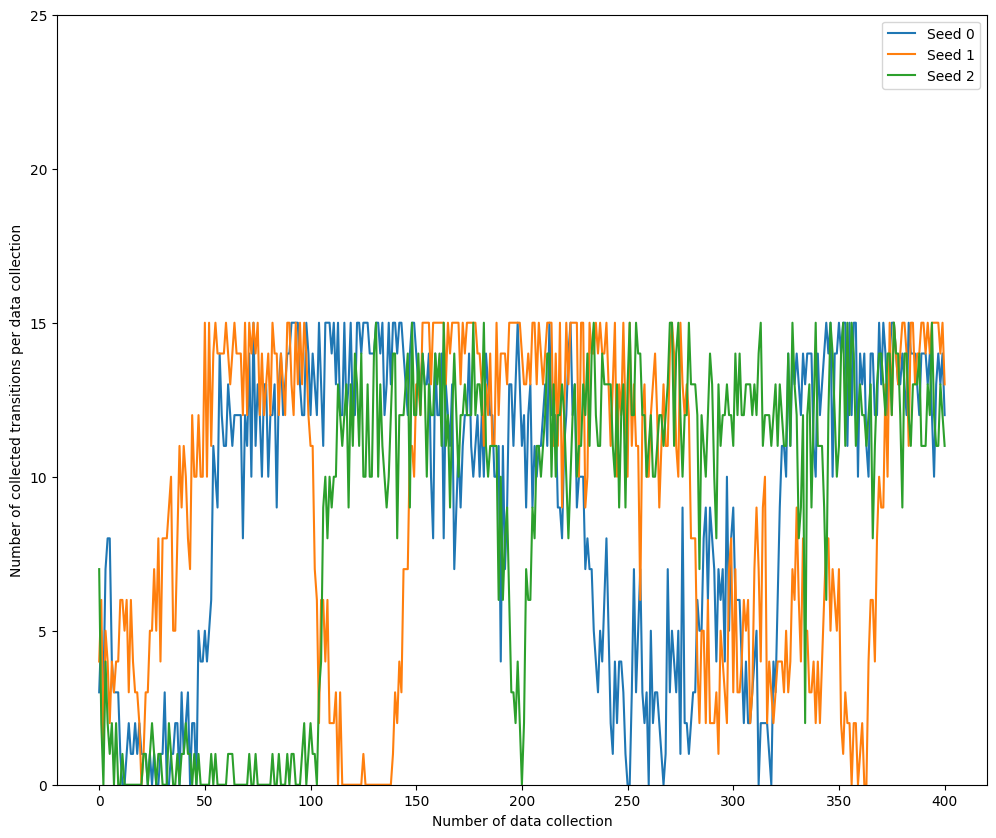

In [28]:
#For specific transition
transition_type = "Grow Plant"
seed = 0
plt.figure(figsize=(12,10))
x = np.arange(transitions_per_episode_per_transition[transition_type].shape[1])
y = transitions_per_episode_per_transition[transition_type]
for seed in range(3):
    plt.plot(x,y[seed], label=f"Seed {seed}")
plt.ylim(0,25)
plt.xlabel("Number of data collection")
plt.ylabel("Number of collected transitions per data collection")
# plt.ylim(0,5)
plt.legend()
plt.show()

In [29]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'O-Random' Color: Red
Baseline: 'O-Ideal' Color: Green
Baseline: 'O-Curriculum' Color: Blue
Baseline: 'O-Hardest' Color: Magenta
Baseline: 'RL-LogP' Color: Cyan
Baseline: 'RL-ALP' Color: White
Baseline: 'RL-ALPEXP' Color: Yellow
-----rule-----:0: '1. If the action is \'You go to\' and the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, wolf), predict "You are standing on the [object]."\n2. If you are standing on an animal\'s seed and the action is \'You give the water\', predict "The objects transform into the [animal]."\n3. If the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, or wolf) and the action is \'You give the water\', predict "The objects transform into the [animal]."\n4. If you are standing on the water and the action is \'You pick up\', predict "In your inventory, there is the water."\n5. If you are standing on the water and the action is \'You pick up the object\', predi

## Distribution of loglikelihood

'1. The first state is: You see the baby pig, the water, the potato seed, the baby rhinoceros, the water, the berry seed, the water, the beet seed. In your inventory, there is nothing.\n\n2. The action was: You go to the water.\n   Change: In your inventory, there is the water.\n\n3. The action was: You pick up the object.\n   Change: In your inventory, there is the water.\n\n4. The action was: You go to the beet seed.\n   Change: You are standing on the beet seed.\n\n5. The action was: You give the beet.\n   Change: The objects transform into the beet.\n\n6. The action was: You give the water.\n   Change: The objects transform into the beet.\n\n7. The action was: You'


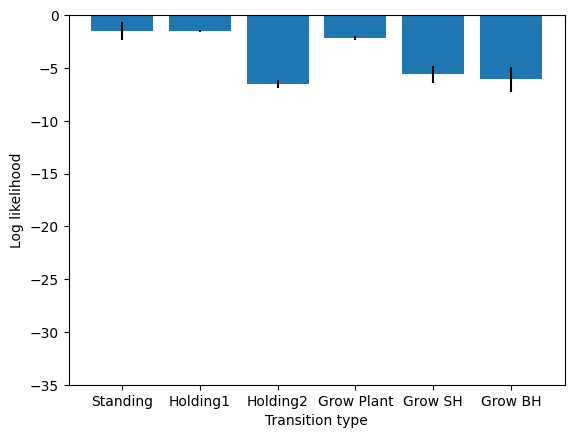

In [30]:
# Plot distribution of loglikelihood for a specific rule
index_rule = (6,-1)
algo_name = "O-Ideal"
rule = all_best_rules[algo_name][index_rule]
ll = all_best_transition_ll[algo_name][index_rule]
print(repr(rule))

# Classify per transition type
mean_values = []
std_values = []
labels = ["Standing", "Holding1", "Holding2", "Grow Plant", "Grow SH", "Grow BH"]
for transition_type, indices in dict_index_transition.items():
    mean_values.append(ll[indices].mean())
    std_values.append(ll[indices].std())
plt.figure()
plt.bar(labels, mean_values, yerr=std_values)
plt.ylabel("Log likelihood")
plt.xlabel("Transition type")
plt.ylim(-35,0)
# plt.title(f"Log likelihood for rule {repr(rule)}")
plt.show()

'1. The first state is: You see the baby pig, the water, the potato seed, the baby rhinoceros, the water, the berry seed, the water, the beet seed. In your inventory, there is nothing.\n\n2. The action was: You go to the water.\n   Change: In your inventory, there is the water.\n\n3. The action was: You pick up the object.\n   Change: In your inventory, there is the water.\n\n4. The action was: You go to the beet seed.\n   Change: You are standing on the beet seed.\n\n5. The action was: You give the beet.\n   Change: The objects transform into the beet.\n\n6. The action was: You give the water.\n   Change: The objects transform into the beet.\n\n7. The action was: You'


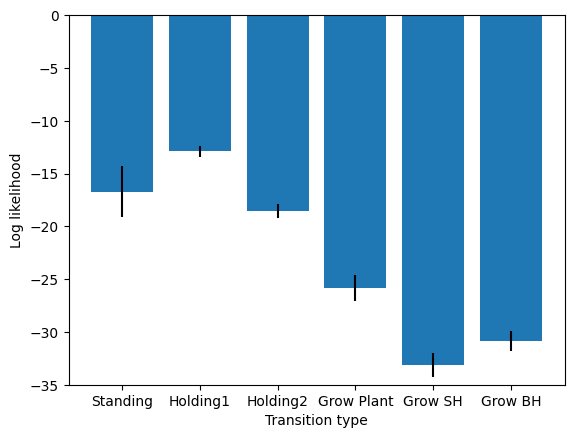

In [31]:
# Plot distribution of loglikelihood for the None rule
ll = np.array(norule_transition_likelihood_lst)[0]
print(repr(rule))

# Classify per transition type
mean_values = []
std_values = []
labels = ["Standing", "Holding1", "Holding2", "Grow Plant", "Grow SH", "Grow BH"]
for transition_type, indices in dict_index_transition.items():
    mean_values.append(ll[indices].mean())
    std_values.append(ll[indices].std())
plt.figure()
plt.bar(labels, mean_values, yerr=std_values)
plt.ylabel("Log likelihood")
plt.xlabel("Transition type")
plt.ylim(-35,0)
# plt.title(f"Log likelihood for rule {repr(rule)}")
plt.show()

## Plot relation data collected, rule generated

In [32]:
#Plot the collected transitions per episode for a specific algorithm and transition type

# plt.figure(figsize=(12,10))
# x = np.arange(transitions_per_episode_per_transition.shape[1])
# y = transitions_per_episode_per_transition.mean(axis=0)
# yerr=transitions_per_episode_per_transition.std(axis=0)
# plt.plot(x,y, label=[transition_type])
# plt.fill_between(x, y-yerr, y+yerr, alpha=0.2)
# plt.ylim(0,25)
# plt.xlabel("Number of data collection")
# plt.ylabel("Number of collected transitions per data collection")
# # plt.ylim(0,5)
# plt.legend()
# plt.show()

<Figure size 640x480 with 0 Axes>

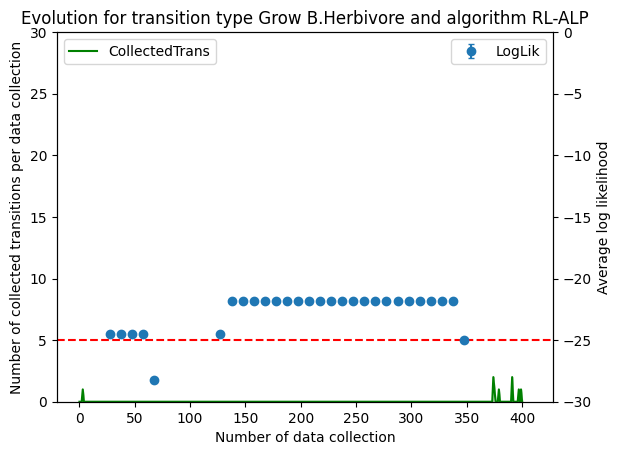

In [33]:
algo_name = "RL-ALP"
transition_type = "Grow B.Herbivore"
for seed in range(1):
    seed = [seed]
    # Compute evolution of collected data
    transitions_per_episode_per_transition = []
    for _seed in range(all_used_transitions[algo_name].shape[0]):
        all_values = []
        for step in range(all_used_transitions[algo_name].shape[1]):
            all_values.append(all_used_transitions[algo_name][_seed, step].get(transition_type, 0))
        transitions_per_episode_per_transition.append(all_values)
    transitions_per_episode_per_transition = np.array(transitions_per_episode_per_transition)

    ## PLot the evolution of the number of collected transitions per episode
    plt.figure()
    fig, ax1 = plt.subplots()
    x = np.arange(transitions_per_episode_per_transition.shape[1])
    y = transitions_per_episode_per_transition[seed].mean(axis=0)
    yerr=transitions_per_episode_per_transition[seed].std(axis=0)
    ax1.plot(x,y, label=["CollectedTrans"], color="g")
    ax1.fill_between(x, y-yerr, y+yerr, alpha=0.2, color="g")
    ax1.set_xlabel("Number of data collection")
    ax1.set_ylabel("Number of collected transitions per data collection")
    ax1.legend(loc='upper left')
    ax1.axhline(y=5, color='r', linestyle='--', label='y=5')
    ax1.set_ylim(0,30)
    # Compute evolution of loglikelihood of the transition for the algorithm on all seeds
    average_size = 10
    kernel = np.ones(average_size) / average_size
    ## Get the best rules for each particle and data collection for each traj type
    _ll_per_transition = all_best_transition_ll[algo_name][:,:,dict_index_transition[transition_type]].mean(axis=-1)

    ax2 = ax1.twinx()
    ## Add no rule as first collect:
    average_mean_ll = np.convolve(_ll_per_transition[seed].mean(axis=0), kernel, mode='valid')[::average_size]
    average_std_ll = np.convolve(_ll_per_transition[seed].std(axis=0), kernel, mode='valid')[::average_size]
    #Plot
    ax2.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label="LogLik", capsize=2, fmt='o')
    ax2.set_xlabel("Number of data collection")
    ax2.set_ylabel("Average log likelihood")
    ax2.set_ylim(-30,0)
    ax2.legend(loc='upper right')
    plt.title(f"Evolution for transition type {transition_type} and algorithm {algo_name}")
    plt.show()

## Embeddings

In [34]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [35]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

In [48]:
plot_every = 20

In [46]:
#For a specific algo on the different seeds
algo_index = 0
for algo_index in range(len(all_baselines_name)):
    b_name = all_baselines_name[algo_index]
    all_inertia_scores = []
    # Plot the embeddings
    # plt.figure(figsize=(15,10))
    start_index = algo_index * len(all_rules[b_name].flatten())
    for seed in range(len(all_data[b_name])):
        indices = np.arange(start_index, start_index + len(all_rules[b_name][seed]))
        # plt.scatter(proj_embeddings[indices, 0], proj_embeddings[indices, 1], label=f"Seed {seed}")
        mean_cluster = np.mean(proj_embeddings[indices], axis=0)
        #Dispersion of the cluster
        inertia_score = np.sum(np.sum(((proj_embeddings[indices]- mean_cluster))**2, axis=-1), axis=0)
        all_inertia_scores.append(inertia_score)
        start_index += len(all_rules[b_name][seed])

    print(f"Mean inertia score for {b_name}: {np.mean(all_inertia_scores):.0f} $\pm$ {np.std(all_inertia_scores):.0f}")
    # plt.legend()
    # plt.xlabel("First Dimension")
    # plt.ylabel("Second Dimension")
    # plt.title("2D T-SNE of the rules generated by O-Hardest")
    # plt.show()

Mean inertia score for O-Random: 4324698 $\pm$ 451178
Mean inertia score for O-Ideal: 4664994 $\pm$ 945628
Mean inertia score for O-Curriculum: 2853112 $\pm$ 1840782
Mean inertia score for O-Hardest: 2862070 $\pm$ 1030090
Mean inertia score for RL-LogP: 4569908 $\pm$ 363271
Mean inertia score for RL-ALP: 3627665 $\pm$ 363374
Mean inertia score for RL-ALPEXP: 4920668 $\pm$ 489195


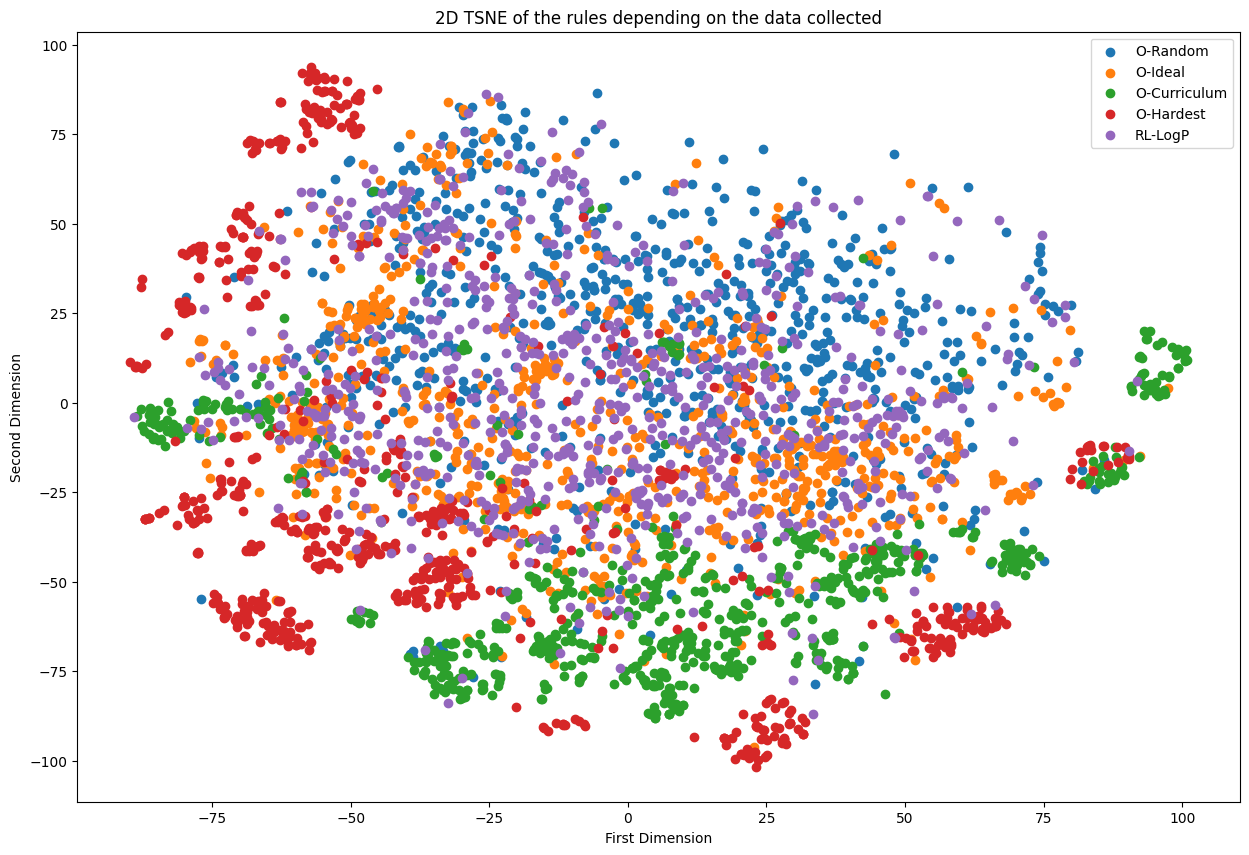

In [49]:
# # Enable interactive backend
# %matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::plot_every].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(["O-Random","O-Ideal","O-Curriculum","O-Hardest", "RL-LogP"]):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()):plot_every,0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()):plot_every,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# # Add interactive cursor
# cursor = mplcursors.cursor(hover=True)
# # Define the hover function
# @cursor.connect("add")
# def on_add(sel):
#     sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")
plt.title("2D TSNE of the rules depending on the data collected")
plt.show()

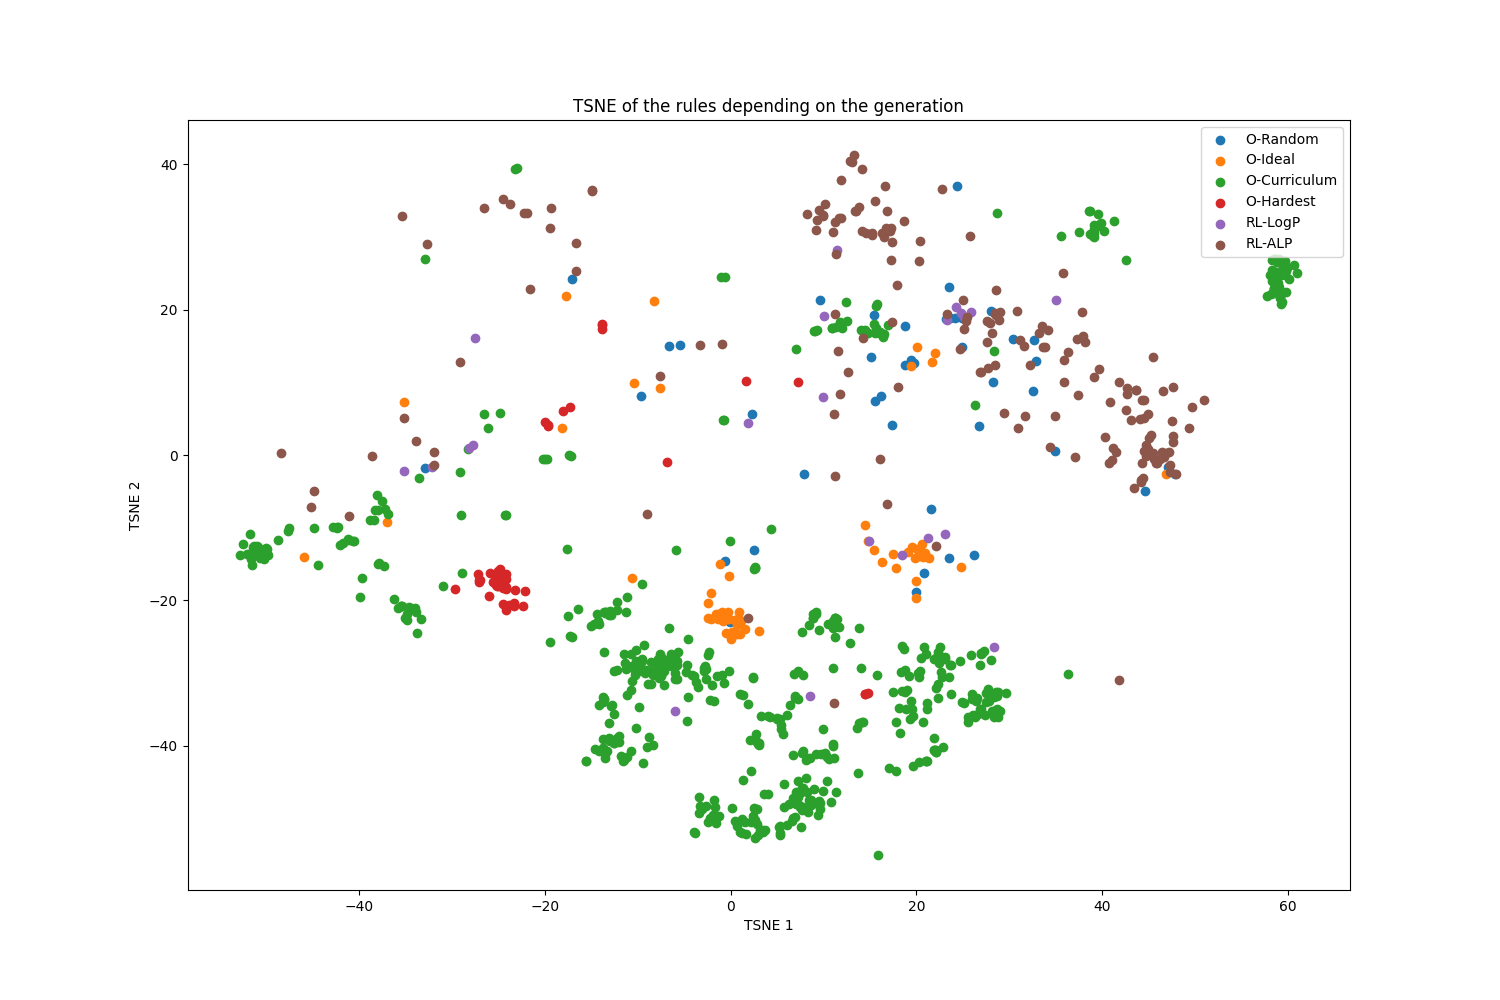

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::plot_every].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -700
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::plot_every].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::plot_every].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [ ]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings_pca = pca.fit_transform(embeddings)

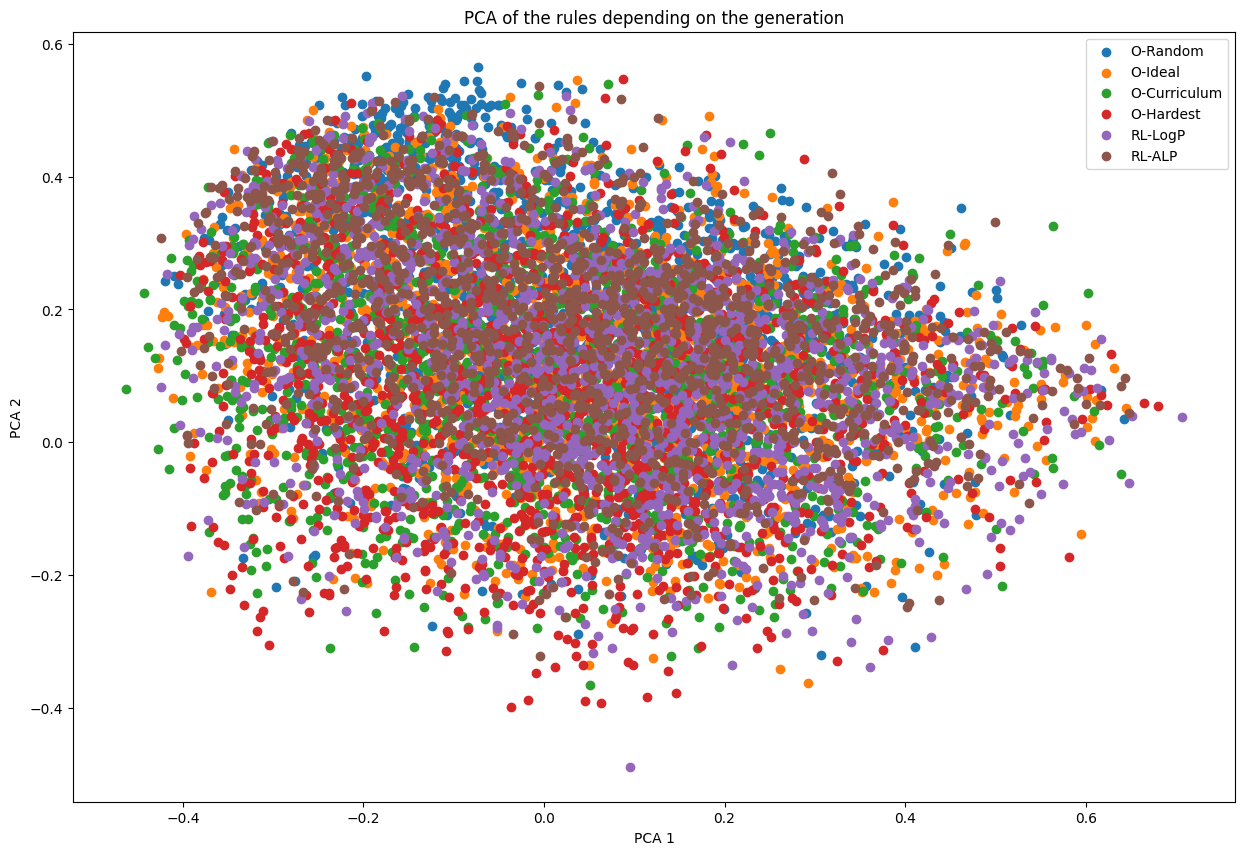

In [ ]:
# # Enable interactive backend
# %matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::plot_every].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings_pca[start_index:start_index+len(all_rules[b_name][:, ::plot_every].flatten()),0], proj_embeddings_pca[start_index:start_index+len(all_rules[b_name][:, ::plot_every].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::plot_every].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

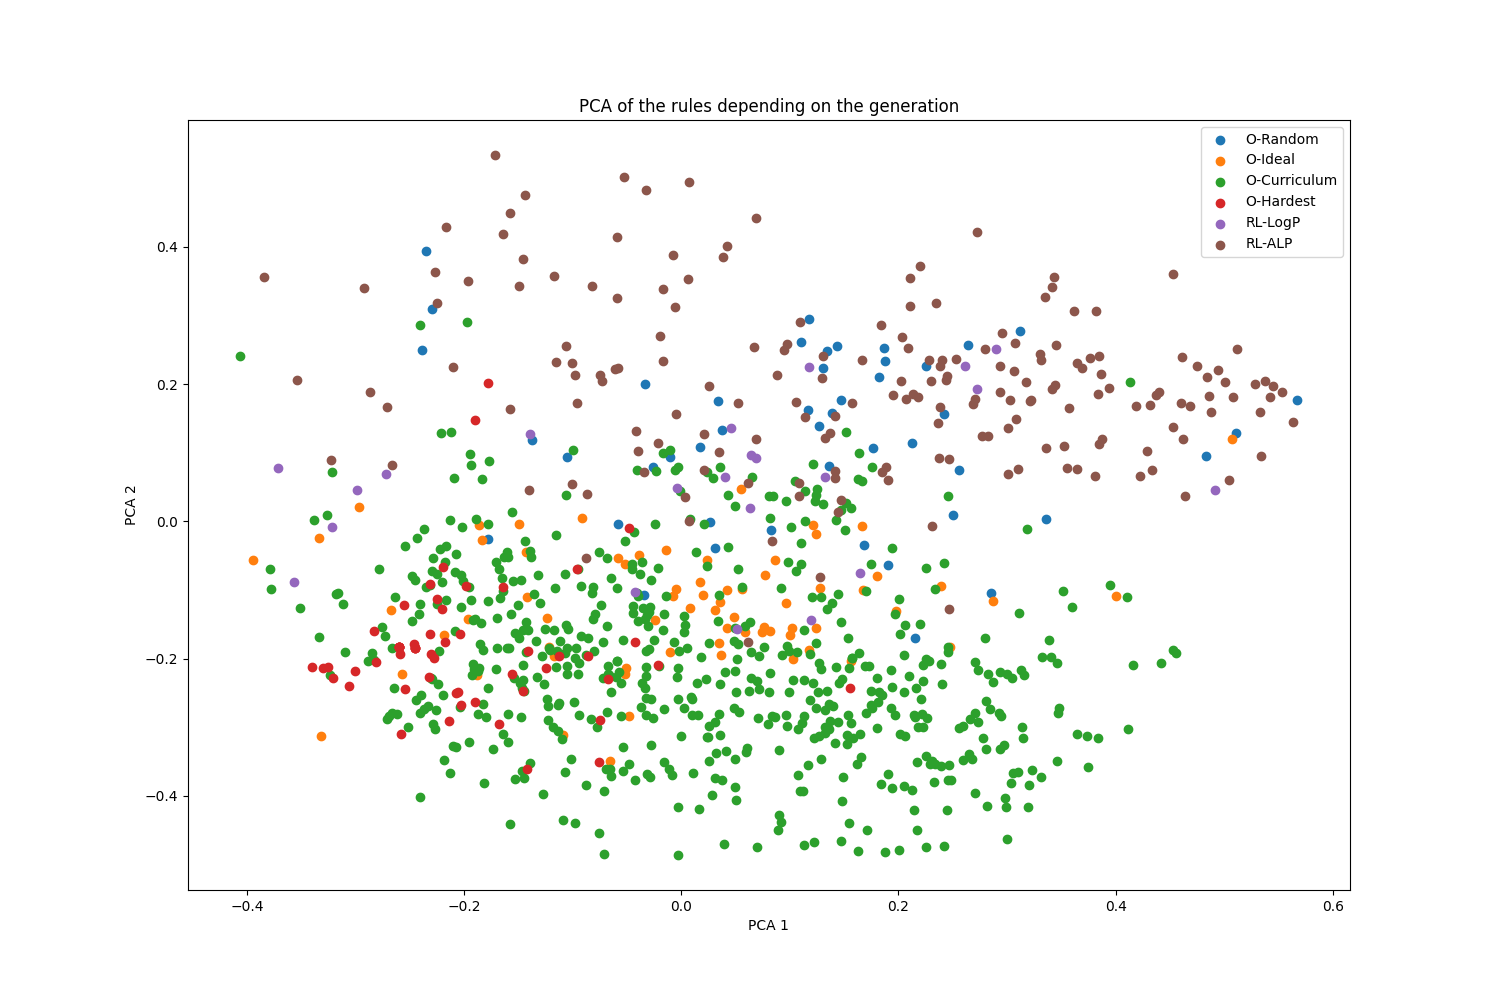

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::plot_every].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -720
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::plot_every].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings_pca[mask_index & mask_likelihood,0], proj_embeddings_pca[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::plot_every].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()